### Check of .env file werkt.

In [49]:
from dotenv import load_dotenv
import os

load_dotenv()  # moet bovenaan staan, vóór het gebruik van os.getenv

print("DB_SERVER:", os.getenv("DB_SERVER"))
print("DB_NAME:", os.getenv("DB_NAME"))
print("DB_USER:", os.getenv("DB_USER"))
print("DB_PASSWORD:", os.getenv("DB_PASSWORD")) 

DB_SERVER: estrategydb03\sql2k19
DB_NAME: None
DB_USER: 4food
DB_PASSWORD: 4food


### Verbinden met dataset via info uit .env file. 

In [50]:
import pandas as pd
import pyodbc
from dotenv import load_dotenv
import os
load_dotenv()
conn = pyodbc.connect(
        f"DRIVER={{SQL Server}};"
        f"SERVER={os.getenv('DB_SERVER')};"
        f"UID={os.getenv('DB_USER')};"
        f"PWD={os.getenv('DB_PASSWORD')}"
    )

query = "SELECT * FROM [4FOOD.Matthijs.JJO].[dbo].[orderinfo]"
df_sql = pd.read_sql_query(query, conn)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)
df_sql.head(5)

C:\Users\aidan\AppData\Local\Temp\ipykernel_4008\3195163646.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sql = pd.read_sql_query(query, conn)


,id,orderType,orderStatus,clientId,clientPlanGroupId,orderDate,orderNumber,orderNumberClient,orderNumberYear,deliveryAddressId,deliveryDate,planningDate,planningComment,invoiceComment,orderModificationDate,removed,versioninfo,importID,earliestDeliveryDate,latestDeliveryDate,invoiceAddressId,ventureAddressId,loadDateAndTime,characteristicId,transportHandling,contactpersonId,ventureCostCenterID,deliveryComment,carrierComment,sourcetype,sourceid,clientTotalDiscount
0,5169,2,4,D017,None,2017-05-01 10:32:25.313,20170001,test,1,839.0,2017-05-25,2017-05-25,,,2017-05-01 00:00:00.000,False,b'\x00\x00\x00\x00\x01rK2',,None,None,None,None,2017-05-25,None,2,NaN,None,None,None,1,NaN,None
1,5170,2,5,D017,None,2017-05-01 11:14:24.663,20170002,,2,839.0,2017-05-02,2017-05-02,,,2017-05-01 00:00:00.000,True,b'\x00\x00\x00\x00\x01\x88\xbc\xcf',,None,None,None,None,2017-05-02,None,2,NaN,None,None,None,1,NaN,None
2,5171,2,1,K025,None,2017-05-01 13:45:56.417,20170003,01052017,3,938.0,2017-05-22,2017-05-22,,,2017-08-04 10:24:04.867,False,b'\x00\x00\x00\x00\x00)\x11\x1d',,None,None,None,None,2017-05-22,None,2,NaN,None,,None,1,NaN,None
3,5172,2,5,K003,None,2017-05-02 09:02:12.697,20170004,02052017,4,NaN,2017-05-02,2017-05-02,,,2017-05-02 09:34:02.577,True,b'\x00\x00\x00\x00\x01\xf6\\\x19',,None,None,None,None,2017-05-02,None,2,NaN,None,None,None,1,NaN,None
4,5173,2,3,C026,None,2017-05-02 15:30:48.067,20170005,4500251768,5,1139.0,2017-05-16,2017-05-16,,,2017-05-16 16:54:32.507,False,b'\x00\x00\x00\x00\x01rEZ',,None,None,None,None,2017-05-16,None,2,NaN,None,,None,1,NaN,None


### Visualisatie van data uit Mattijs.JJO database(orderinfo tabel) jaaroverzicht aantal orders en trendlijn.

Gebruik datumkolom: orderDate
Minder dan 8 jaar historie beschikbaar; toon volledige periode.
Jaar 2025 uitgesloten uit visualisaties/statistieken.


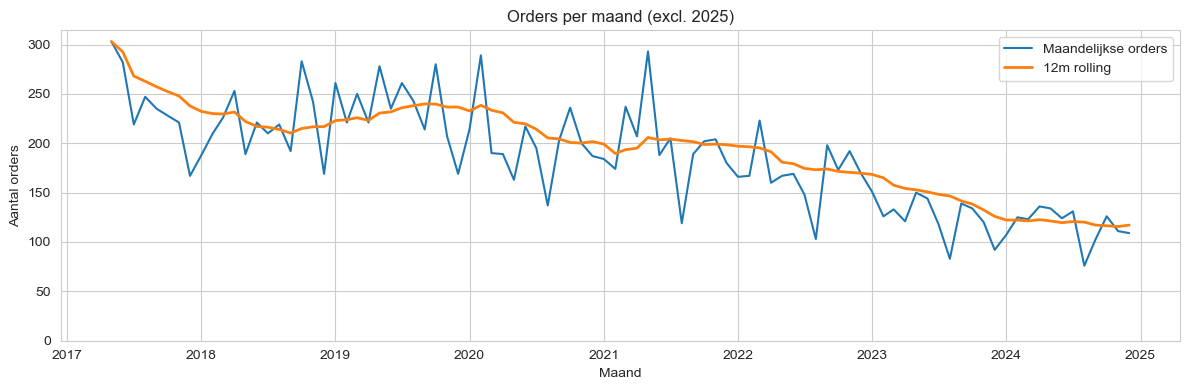

C:\Users\aidan\AppData\Local\Temp\ipykernel_4008\4203074200.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=yearly.index, y=yearly.values, palette="Blues")


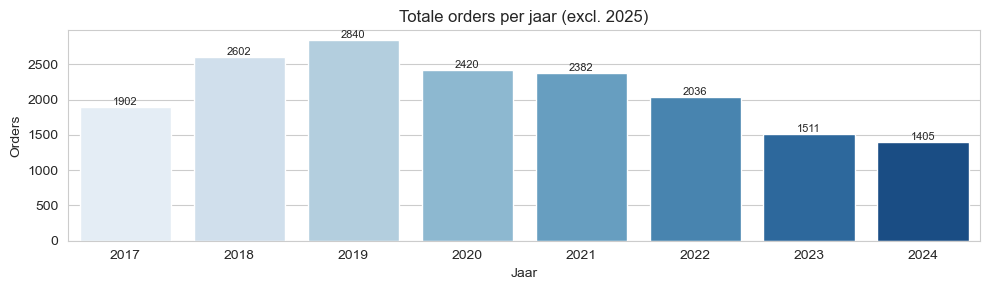

Periode getoond (excl. 2025): 2017-05-01 t/m 2024-12-01
Gemiddeld per maand: 185.84782608695653
Mediaan per maand: 189.0
Trend (laatste 12m vs eerdere 12m):
 - Laatste 12m: 117.1
 - Vorige 12m: 125.9
 - Verandering: -7.0%


In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
sns.set_style("whitegrid")

# 1. Kies datumkolom (prioriteit) uit aanwezige kolommen
prioriteit = ["orderDate","deliveryDate","planningDate","loadDateAndTime"]
kandidaten = [c for c in prioriteit if c in df_sql.columns]
if not kandidaten:
    # fallback: elke kolom met 'date' of 'time' in naam
    kandidaten = [c for c in df_sql.columns if "date" in c.lower() or "time" in c.lower()]

if not kandidaten:
    raise ValueError("Geen datumkolom gevonden in df_sql.")

DATE_COL = kandidaten[0]
print("Gebruik datumkolom:", DATE_COL)

# 2. Conversie naar datetime
df_dates = df_sql[[DATE_COL]].copy()
df_dates[DATE_COL] = pd.to_datetime(df_dates[DATE_COL], errors="coerce")
df_dates = df_dates.dropna(subset=[DATE_COL])

if df_dates.empty:
    raise ValueError("Alle datums zijn NaT na conversie.")

# 3. Dagelijkse telling -> maandelijkse aggregatie
daily_counts = df_dates.groupby(df_dates[DATE_COL].dt.date).size().rename("orders")
daily_counts.index = pd.to_datetime(daily_counts.index)
monthly = daily_counts.resample("MS").sum()

# 4. Filter laatste 8 jaar (indien voldoende historie)
max_d = monthly.index.max()
min_needed = max_d - pd.DateOffset(years=8)
if monthly.index.min() > min_needed:
    print("Minder dan 8 jaar historie beschikbaar; toon volledige periode.")
    monthly_8y = monthly.copy()
else:
    monthly_8y = monthly[monthly.index >= min_needed]

# 5. Rolling gemiddelde
monthly_8y_roll = monthly_8y.rolling(12, min_periods=1).mean()

# === jaar 2025 uitsluiten ===
mask25 = monthly_8y.index.year == 2025
if mask25.any():
    print("Jaar 2025 uitgesloten uit visualisaties/statistieken.")
monthly_plot = monthly_8y[~mask25]
monthly_plot_roll = monthly_plot.rolling(12, min_periods=1).mean()

# 6. Plot lijn + rolling (zonder 2025)
plt.figure(figsize=(12,4))
plt.plot(monthly_plot.index, monthly_plot.values, label="Maandelijkse orders", color="tab:blue")
plt.plot(monthly_plot_roll.index, monthly_plot_roll.values, label="12m rolling", color="tab:orange", linewidth=2)
plt.ylim(bottom=0)
plt.title("Orders per maand (excl. 2025)")
plt.ylabel("Aantal orders")
plt.xlabel("Maand")
plt.legend()
plt.tight_layout()
plt.show()

# 7. Jaarlijkse totalen (balk) (zonder 2025)
yearly = monthly_plot.groupby(monthly_plot.index.year).sum()
plt.figure(figsize=(10,3))
sns.barplot(x=yearly.index, y=yearly.values, palette="Blues")
plt.title("Totale orders per jaar (excl. 2025)")
plt.ylabel("Orders")
plt.xlabel("Jaar")
for i,v in enumerate(yearly.values):
    plt.text(i, v, f"{int(v)}", ha="center", va="bottom", fontsize=8)
plt.tight_layout()
plt.show()

# 8. Kernstatistieken (zonder 2025)
print("Periode getoond (excl. 2025):", monthly_plot.index.min().date(), "t/m", monthly_plot.index.max().date())
print("Gemiddeld per maand:", monthly_plot.mean())
print("Mediaan per maand:", monthly_plot.median())
print("Trend (laatste 12m vs eerdere 12m):")
if len(monthly_plot) >= 24:
    last12 = monthly_plot.tail(12).mean()
    prev12 = monthly_plot.tail(24).head(12).mean()
    pct = ((last12 - prev12)/prev12*100) if prev12 != 0 else float("nan")
    print(f" - Laatste 12m: {last12:.1f}")
    print(f" - Vorige 12m: {prev12:.1f}")
    print(f" - Verandering: {pct:.1f}%")
else:
    print(" - Onvoldoende maanden (<24) voor vergelijking.")

### inladen Napoleon database(bestellingen)

In [52]:
import pandas as pd
import pyodbc
from dotenv import load_dotenv
import os
load_dotenv()
conn = pyodbc.connect(
        f"DRIVER={{SQL Server}};"
        f"SERVER={os.getenv('DB_SERVER')};"
        f"UID={os.getenv('DB_USER')};"
        f"PWD={os.getenv('DB_PASSWORD')}"
    )

query = "SELECT * FROM [4food.napoleon.productie].[dbo].[bestellingen]"
df_sql2 = pd.read_sql_query(query, conn)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)
df_sql2.head(5)

C:\Users\aidan\AppData\Local\Temp\ipykernel_4008\2044741791.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sql2 = pd.read_sql_query(query, conn)


,id,type,code,leverancier,contract,bestel_datum,bestelbonnr,behandeld_door,losplaats,aantal,prijs_pe,gew_leverdatum,bev_leverdatum,datum_geleverd,eigenaar,status,versioninfo,magazijn,prijsper,opmerking,contactid,deleted,ordernum,uniqueordernum,addressID,orderType,conversionID,approved_booked_by,baseLotCode,baseLotCodeManuallyChanged,orderNumberSupplier,externalReference,loadingDate,carrierID,locationID,cmrNumber,administrativeNumber,qualityCheck,fee,currencyID,currencyRate,weightUnitConversionID,vatgroupid,clientCode,orderModificationDate,isNotLinkedArticle,supplierArticleCode,supplierArticleDescription,purchaseUnitId,commisioner_id,orderInfoId,salesorderrowid,purchasepriceunit,originCountryID,transportdata,itemweight,turnovergroupid,transportconfirmationremarks
0,32,0,101033,31,NaN,2007-08-28,IO070001,maria,,25000.0,0.43,2007-09-04 00:00:00,2007-09-04 00:00:00,NaT,None,1,b'\x00\x00\x00\x00\x00\xb4\x00l',GRONDST,1,None,NaN,False,1,1,NaN,0,NaN,None,None,False,None,None,None,None,None,None,None,None,0.0,EUR,1.0,None,None,None,2007-08-28,False,Glucomalt 15 A,glucosestroop,1.0,None,None,None,None,None,None,NaN,None,None
1,33,0,101033,31,NaN,2007-08-28,IO070002,maria,,25000.0,0.43,2007-09-05 00:00:00,2007-09-05 00:00:00,NaT,None,1,b'\x00\x00\x00\x00\x00\xb4\x00m',GRONDST,1,None,NaN,False,2,2,NaN,0,NaN,None,None,False,None,None,None,None,None,None,None,None,0.0,EUR,1.0,None,None,None,2007-08-28,False,Glucomalt 15 A,glucosestroop,1.0,None,None,None,None,None,None,NaN,None,None
2,34,0,101206,4,NaN,2007-08-23,IO070034,maria,,240.0,5.95,2007-09-07 00:00:00,2007-09-07 00:00:00,NaT,None,1,b'\x00\x00\x00\x00\x00\xb4\x00n',GRONDST,1,None,NaN,False,3,3,NaN,0,NaN,None,None,False,None,None,None,None,None,None,None,None,0.0,EUR,1.0,None,None,None,2007-08-23,False,SL082.00216,Mehrfrucht Rot Konzentraat,1.0,None,None,None,None,None,None,NaN,None,None
3,35,0,101705,6,NaN,2007-08-30,IO070035,maria,,20000.0,1.17,2007-09-03 00:00:00,2007-09-03 00:00:00,NaT,None,1,"b'\x00\x00\x00\x00\x00\xb2\xf2""'",GRONDST,1,None,NaN,False,4,4,NaN,0,NaN,None,None,False,None,None,None,None,None,None,None,None,0.0,EUR,1.0,None,None,None,2007-08-30,False,None,None,1.0,None,None,None,None,None,None,NaN,None,None
4,36,0,101477,51,NaN,2007-08-30,IO070005,maria,,500.0,3.87,2007-09-20 00:00:00,2007-09-20 00:00:00,NaT,None,1,b'\x00\x00\x00\x00\x00\xb4\x00o',GRONDST,1,None,0.0,False,5,5,NaN,0,NaN,None,None,False,None,None,None,None,None,None,None,None,0.0,EUR,1.0,None,None,None,2007-08-30,False,DUB 0025,pan oil leader T,1.0,None,None,None,None,None,None,NaN,None,None


### visualisatie 

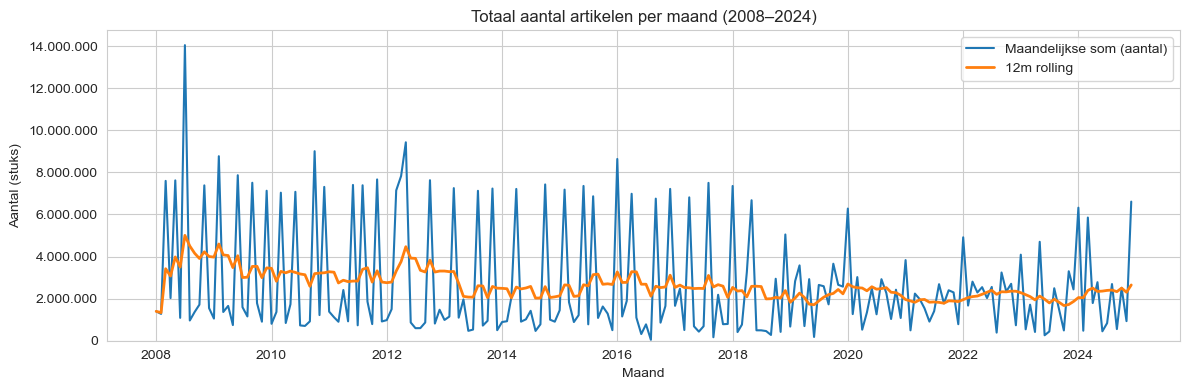

C:\Users\aidan\AppData\Local\Temp\ipykernel_4008\316078386.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=yearly_qty.index, y=yearly_qty.values, palette="Blues")


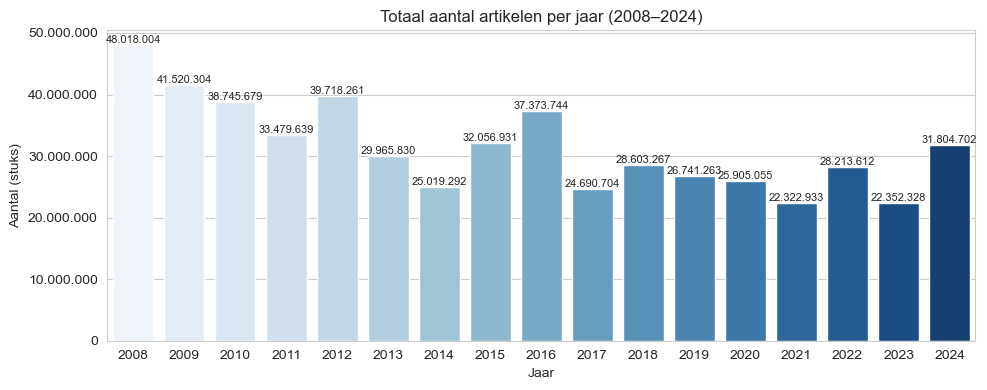

In [53]:
# === Overzicht visualisaties voor bestellingen (df_sql2) ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

sns.set_style("whitegrid")

df_po = df_sql2.copy()

# Kolommapping (pas aan als je andere namen gebruikt)
COLS = {
    "order_date": "bestel_datum",
    "expected_date": "gew_leverdatum",
    "confirmed_date": "bev_leverdatum",
    "delivered_date": "datum_geleverd",
    "supplier": "leverancier",
    "status": "status",
    "qty": "aantal",
    "unit_price_a": "prijsper",
    "unit_price_b": "prijs_pe",
}

def fmt_thousands(x, pos):
    try:
        return f"{int(x):,}".replace(",", ".")
    except Exception:
        return str(x)

# Datums parsen
for c in ["order_date", "expected_date", "confirmed_date", "delivered_date", "orderModificationDate", "loadingDate"]:
    name = COLS.get(c, c)
    if name in df_po.columns:
        df_po[name] = pd.to_datetime(df_po[name], errors="coerce")

# Numeriek parsen
for c in ["qty", "unit_price_a", "unit_price_b"]:
    name = COLS.get(c, c)
    if name in df_po.columns:
        df_po[name] = pd.to_numeric(df_po[name], errors="coerce")

# Orderwaarde (optioneel, niet nodig voor aantallen)
unit_price_col = None
if COLS["unit_price_a"] in df_po.columns:
    unit_price_col = COLS["unit_price_a"]
elif COLS["unit_price_b"] in df_po.columns:
    unit_price_col = COLS["unit_price_b"]

if COLS["qty"] in df_po.columns and unit_price_col:
    df_po["order_value"] = df_po[COLS["qty"]] * df_po[unit_price_col]

# === Filter periode 2008–2024 ===
date_col = COLS["order_date"]
qty_col = COLS["qty"]
if date_col in df_po.columns and df_po[date_col].notna().any():
    df_po_range = df_po[(df_po[date_col].dt.year >= 2008) & (df_po[date_col].dt.year <= 2024)].copy()
else:
    raise ValueError("Geen geldige bestel_datum in dataset.")

# Zorg dat er een geldige qty-kolom is
if qty_col not in df_po_range.columns:
    raise ValueError(f"Kolom met aantallen ontbreekt: {qty_col}")

# === 1) Maandelijkse som van aantallen (lijn + 12m rolling) ===
tmp = df_po_range.dropna(subset=[date_col, qty_col]).copy()
daily_qty = tmp.groupby(tmp[date_col].dt.date)[qty_col].sum().rename("qty")
daily_qty.index = pd.to_datetime(daily_qty.index)

monthly_qty = daily_qty.resample("MS").sum()
roll12_qty = monthly_qty.rolling(12, min_periods=1).mean()

plt.figure(figsize=(12,4))
plt.plot(monthly_qty.index, monthly_qty.values, label="Maandelijkse som (aantal)", color="tab:blue")
plt.plot(roll12_qty.index, roll12_qty.values, label="12m rolling", color="tab:orange", linewidth=2)
plt.ylim(bottom=0)
plt.title("Totaal aantal artikelen per maand (2008–2024)")
plt.ylabel("Aantal (stuks)")
plt.xlabel("Maand")
plt.legend()
ax = plt.gca()
ax.ticklabel_format(axis="y", style="plain")  # geen wetenschappelijke notatie
ax.yaxis.set_major_formatter(FuncFormatter(fmt_thousands))
plt.tight_layout()
plt.show()

# === 2) Jaarlijkse totalen (balk) op basis van aantallen ===
yearly_qty = monthly_qty.groupby(monthly_qty.index.year).sum()

fig, ax = plt.subplots(figsize=(10,4))
sns.barplot(ax=ax, x=yearly_qty.index, y=yearly_qty.values, palette="Blues")
ax.set_title("Totaal aantal artikelen per jaar (2008–2024)")
ax.set_ylabel("Aantal (stuks)")
ax.set_xlabel("Jaar")
ax.ticklabel_format(axis="y", style="plain")
ax.yaxis.set_major_formatter(FuncFormatter(fmt_thousands))

# Waarden boven de balken
for i, v in enumerate(yearly_qty.values):
    ax.text(i, v, f"{int(v):,}".replace(",", "."), ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()

In [54]:
df_po_range.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17291 entries, 347 to 17644
Data columns (total 59 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id                            17291 non-null  int64         
 1   type                          17291 non-null  int64         
 2   code                          17291 non-null  object        
 3   leverancier                   17291 non-null  int64         
 4   contract                      2768 non-null   float64       
 5   bestel_datum                  17291 non-null  datetime64[ns]
 6   bestelbonnr                   17291 non-null  object        
 7   behandeld_door                17291 non-null  object        
 8   losplaats                     17291 non-null  object        
 9   aantal                        17291 non-null  float64       
 10  prijs_pe                      17291 non-null  float64       
 11  gew_leverdatum                1

In [55]:
import pandas as pd
import pyodbc
from dotenv import load_dotenv
import os
load_dotenv()
conn = pyodbc.connect(
        f"DRIVER={{SQL Server}};"
        f"SERVER={os.getenv('DB_SERVER')};"
        f"UID={os.getenv('DB_USER')};"
        f"PWD={os.getenv('DB_PASSWORD')}"
    )

query = "SELECT * FROM [4food.napoleon.productie].[dbo].[jaarschema]"
df_sql3 = pd.read_sql_query(query, conn)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)
df_sql3.head(5)

C:\Users\aidan\AppData\Local\Temp\ipykernel_4008\303688852.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sql3 = pd.read_sql_query(query, conn)


,id,jaar,maand,klant,artikel,aantalhe,versioninfo
0,3,2006,1,None,101-15-0225-0000,1000,b'\x00\x00\x00\x00\x00\x01\x7f\xf2'
1,4,2006,1,None,102-15-0225-0000,1000,b'\x00\x00\x00\x00\x00\x01\x7f\xf3'
2,5,2006,1,None,104-12-0350-0000,500,b'\x00\x00\x00\x00\x00\x01\x7f\xf4'
3,6,2006,2,None,101-15-0225-0000,750,b'\x00\x00\x00\x00\x00\x01\x7f\xf5'
4,7,2006,2,None,102-15-0225-1001,750,b'\x00\x00\x00\x00\x00\x01\x7f\xf6'


In [56]:
df_sql3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26116 entries, 0 to 26115
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           26116 non-null  int64 
 1   jaar         26116 non-null  int64 
 2   maand        26116 non-null  int64 
 3   klant        10487 non-null  object
 4   artikel      26116 non-null  object
 5   aantalhe     26116 non-null  int64 
 6   versioninfo  26116 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.4+ MB


In [57]:
aantal_uniek = df_sql3["artikel"].nunique()
print(aantal_uniek)

1153


In [58]:
aantal_uniek = df_sql3["aantalhe"].nunique()
print(aantal_uniek)

4283


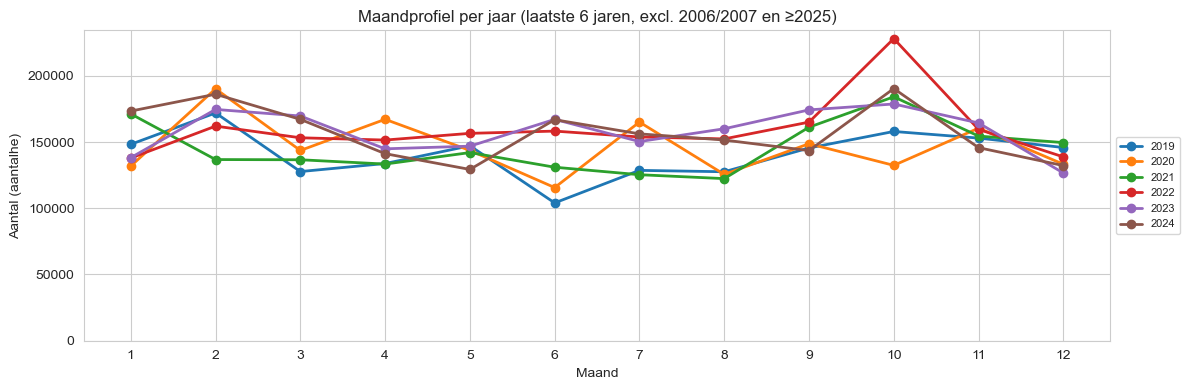

In [59]:
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.ticker import FuncFormatter
sns.set_style("whitegrid")

# Zorg dat fc bestaat met filter (excl. 2006/2007 en >=2025)
try:
    fc
except NameError:
    fc = fc_df.copy()
    fc = fc[~fc["jaar"].isin([2006, 2007])]
    fc = fc[fc["jaar"] <= 2024]
    if "periode" not in fc.columns:
        fc["periode"] = pd.to_datetime(dict(year=fc["jaar"], month=fc["maand"], day=1), errors="coerce")
    fc = fc.dropna(subset=["periode", "aantalhe"])

# Aggregeer per jaar-maand
ym = (fc.groupby(["jaar", "maand"])["aantalhe"].sum().reset_index())
# Zorg voor alle maanden 1..12
months = list(range(1, 13))
pivot_ym = (ym.pivot(index="jaar", columns="maand", values="aantalhe")
              .reindex(columns=months)  # 1..12
              .sort_index())

# 1) Seizoenslijn: maanden (1..12) met aparte lijn per jaar (laatste N jaren)
YEARS_N = 6
years_to_show = pivot_ym.index.sort_values()[-YEARS_N:]

plt.figure(figsize=(12,4))
for y in years_to_show:
    s = pivot_ym.loc[y].fillna(0)
    plt.plot(months, s.values, marker="o", linewidth=2, label=str(y))
plt.ylim(bottom=0)
plt.title(f"Maandprofiel per jaar (laatste {YEARS_N} jaren, excl. 2006/2007 en ≥2025)")
plt.xlabel("Maand"); plt.ylabel("Aantal (aantalhe)")
plt.xticks(months)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=8)
plt.tight_layout()
plt.show()

In [60]:
# Statistische samenvatting van de belangrijkste kolommen in df_po_range
print("Statistische samenvatting van de aantallen (alle bestellingen, 2008–2024):")
print(df_sql2["aantal"].describe())

# Als je ook andere numerieke kolommen wilt samenvatten:
print("\nSamenvatting van alle numerieke kolommen:")
print(df_sql2.describe())

# Voor een samenvatting per artikel:
if "artikel" in df_sql2.columns:
    print("\nSamenvatting per artikel (eerste 5):")

Statistische samenvatting van de aantallen (alle bestellingen, 2008–2024):
count    1.791800e+04
mean     3.148397e+04
std      3.215252e+05
min      1.000000e+00
25%      2.000000e+02
50%      1.500000e+03
75%      2.400000e+04
max      7.409500e+06
Name: aantal, dtype: float64

Samenvatting van alle numerieke kolommen:
                 id          type   leverancier     contract                   bestel_datum        aantal      prijs_pe                 datum_geleverd        status      prijsper     contactid      ordernum  uniqueordernum     addressID  orderType  conversionID      fee  currencyRate          orderModificationDate  purchaseUnitId   itemweight
count  17918.000000  17918.000000  17918.000000  2805.000000                          17918  1.791800e+04  17918.000000                            605  17918.000000  17918.000000  17368.000000  17918.000000    17918.000000  16879.000000    17918.0   7225.000000  17918.0       16586.0                          17918    17299.000000 

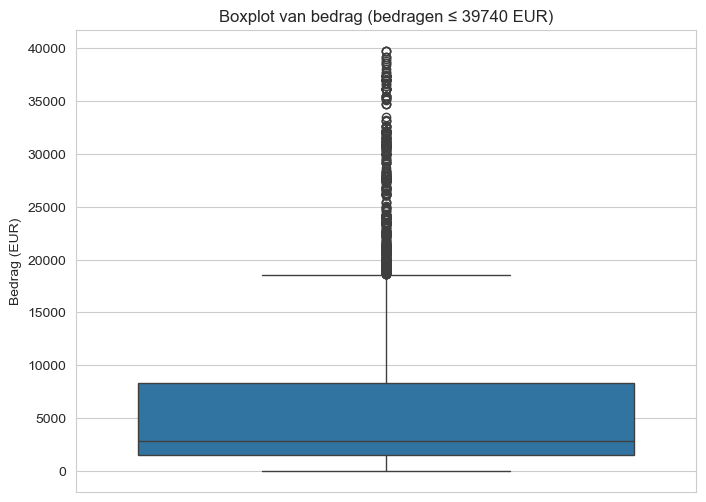

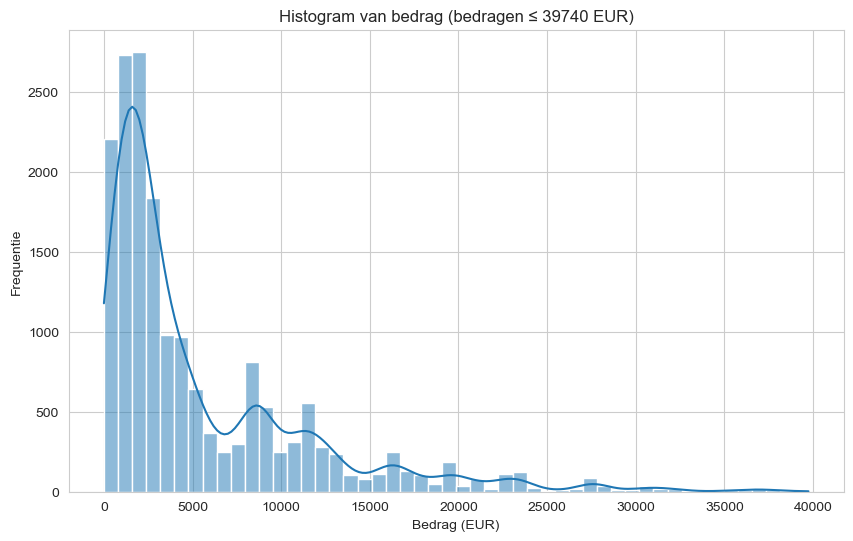

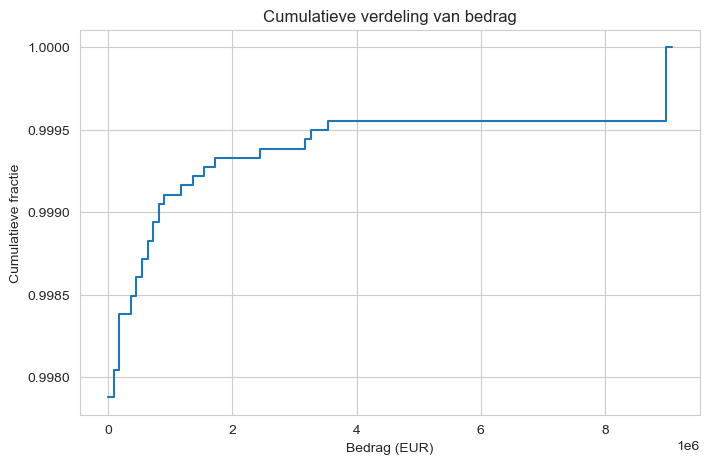

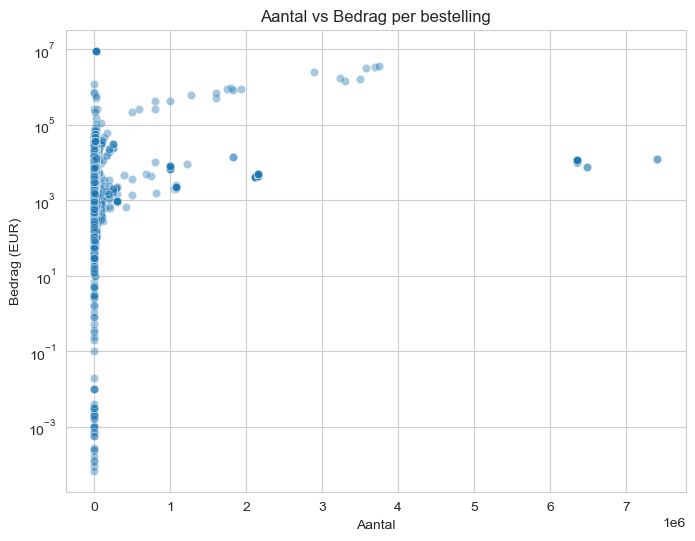

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# --- Bereken bedrag ---
df_sql2['bedrag'] = df_sql2['aantal'] * df_sql2['prijs_pe'] / df_sql2['prijsper']

# Filter extreme waarden voor beter zicht (bijvoorbeeld top 1%)
p99_bedrag = df_sql2['bedrag'].quantile(0.99)
df_plot = df_sql2[df_sql2['bedrag'] <= p99_bedrag]

# --- Boxplot van bedrag ---
plt.figure(figsize=(8,6))
sns.boxplot(y=df_plot['bedrag'])
plt.title(f"Boxplot van bedrag (bedragen ≤ {int(p99_bedrag)} EUR)")
plt.ylabel("Bedrag (EUR)")
plt.show()

# --- Histogram van bedrag ---
plt.figure(figsize=(10,6))
sns.histplot(df_plot['bedrag'], bins=50, kde=True)
plt.title(f"Histogram van bedrag (bedragen ≤ {int(p99_bedrag)} EUR)")
plt.xlabel("Bedrag (EUR)")
plt.ylabel("Frequentie")
plt.show()

# --- Cumulatieve verdeling bedrag ---
plt.figure(figsize=(8,5))
sns.histplot(df_sql2['bedrag'], bins=100, cumulative=True, stat="density", element="step", fill=False)
plt.title("Cumulatieve verdeling van bedrag")
plt.xlabel("Bedrag (EUR)")
plt.ylabel("Cumulatieve fractie")
plt.show()

# --- Scatterplot bedrag vs aantal ---
plt.figure(figsize=(8,6))
sns.scatterplot(x='aantal', y='bedrag', data=df_sql2, alpha=0.4)
plt.yscale("log")  # log-schaal nuttig voor grote spreiding
plt.title("Aantal vs Bedrag per bestelling")
plt.xlabel("Aantal")
plt.ylabel("Bedrag (EUR)")
plt.show()


In [62]:
import pandas as pd
import pyodbc
from dotenv import load_dotenv
import os
load_dotenv()
conn = pyodbc.connect(
        f"DRIVER={{SQL Server}};"
        f"SERVER={os.getenv('DB_SERVER')};"
        f"UID={os.getenv('DB_USER')};"
        f"PWD={os.getenv('DB_PASSWORD')}"
    )

query = "SELECT * FROM [4food.aidan].[dbo].[prognosesNapoleon]"
prognosesNapoleonAidan = pd.read_sql_query(query, conn)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)
prognosesNapoleonAidan.head(5)

C:\Users\aidan\AppData\Local\Temp\ipykernel_4008\848039889.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  prognosesNapoleonAidan = pd.read_sql_query(query, conn)


,id,jaar,maand,klant,artikel,aantalhe
0,1051,2008,1,10002,101-03-3000-0000,88
1,1052,2008,1,10002,101-05-1000-0000,832
2,1053,2008,1,10002,101-12-0225-0000,2000
3,1054,2008,1,10002,101-12-0350-0000,620
4,1055,2008,1,10002,101-15-0225-0000,5687


In [63]:
import pandas as pd
import pyodbc
from dotenv import load_dotenv
import os
load_dotenv()
conn = pyodbc.connect(
        f"DRIVER={{SQL Server}};"
        f"SERVER={os.getenv('DB_SERVER')};"
        f"UID={os.getenv('DB_USER')};"
        f"PWD={os.getenv('DB_PASSWORD')}"
    )

query = "SELECT * FROM [4food.napoleon.productie].[dbo].[opb]"
opbNapoleon = pd.read_sql_query(query, conn)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)
opbNapoleon.head(5)

C:\Users\aidan\AppData\Local\Temp\ipykernel_4008\2172064950.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  opbNapoleon = pd.read_sql_query(query, conn)


,opbnr,caramels,ordersoort,klantnr,ordernrintern,leverdatum,levertijdweek,artikelnummer,nettokg,gereed,palletaantal,opmerking,ordernrklant,handplanning,inpaklijst,tht,versioninfo,betalingsconditie,onderneming,backorder,deleted,status,ordernr,volgnr,orderjaar,orderdatum,korting,soort_art,artnaam,eenheid,orderChangeDate,delivered,mainOrderRow,previousState,originalQuantity,orderInfoId,classificationId,rowStatus,salesContractID,departureDate,externalReference,cmrNumber,invoiceNumber,qualityCheck,loadingWarehouseID,fee,loadingReference,unloadingReference,wagework,planState,planningComment,itemType,planProdDate,planProdQuantity,deliveryConditionID,quantity,priceKG,tuWeight,actualTuWeight,rowNumber,externalDelivery,userid,username,loadingLocationID,pickupFromSupplierId,venturecostcenterid,pallettypecode,palletdatacode,tuperpallet,originCountryID,vatgroupid,createdBy,createdOn,turnovergroupid,externalpicking,basedOnOrderRowId,supplierremark,hidehistory,lastpackagecompletion
0,22,False,0,10002,VO070006,2007-05-08,0.0,101-15-0225-0000,0.0,True,0.0,,tst_pre,False,False,2007-05-01,b'\x00\x00\x00\x00\x00\xfc\xa1b',0,001,0.0,True,0,6,0,2007.0,2007-11-20 16:57:27.243,0.0,0,NAP Lempur 15 x 225 g-e-,,NaT,NaN,NaN,0,4050.0,9.0,None,0,None,None,None,None,None,None,None,0.0,None,None,False,0,None,4,None,None,NaN,4050.0,1.902222,3.375,None,1,False,NaN,None,None,None,None,None,None,None,None,3.0,NaN,NaT,NaN,None,NaN,None,False,None
1,23,False,2,10002,VO070007,2007-06-07,0.0,201-12-0275-0000,0.0,True,0.0,,,False,False,2009-06-07,b'\x00\x00\x00\x00\x00\xfc\xa1c',0,001,0.0,True,0,7,0,2007.0,2007-11-20 16:57:27.243,0.0,0,AF Classic 12 x 275 g-e-,,NaT,NaN,NaN,0,3300.0,10.0,None,0,None,None,None,None,None,None,None,0.0,None,None,False,0,None,4,None,None,NaN,3300.0,1.772727,3.300,None,1,False,NaN,None,None,None,None,None,None,None,None,3.0,NaN,NaT,NaN,None,NaN,None,False,None
2,24,False,0,10002,VO070009,2007-07-26,0.0,430-12-0275-0000,0.0,True,0.0,,Test intern,False,False,2007-07-25,b'\x00\x00\x00\x00\x00\xfc\xa1d',1,,0.0,True,0,9,0,2007.0,2007-11-20 16:57:27.243,0.0,0,Zwart-wit 12 x 275 g-e-,,NaT,NaN,NaN,0,13200.0,11.0,None,0,None,None,None,None,None,None,None,0.0,None,None,False,0,None,4,None,None,NaN,13200.0,1.696970,3.300,None,1,False,NaN,None,None,None,None,None,None,None,None,3.0,NaN,NaT,NaN,None,NaN,None,False,None
3,25,False,2,10002,VO070010,2007-08-08,0.0,101-12-0225-0000,0.0,True,0.0,,1,False,False,2007-08-01,b'\x00\x00\x00\x00\x00\xfc\xa1e',1,,0.0,True,0,10,0,2007.0,2007-11-20 16:57:27.243,0.0,0,NAP Lempur 12 x 225 g.-e-AH,,NaT,NaN,NaN,0,2700.0,12.0,None,0,None,None,None,None,None,None,None,0.0,None,None,False,0,None,4,None,None,NaN,2700.0,1.911111,2.700,None,1,False,NaN,None,None,None,None,None,None,None,None,3.0,NaN,NaT,NaN,None,NaN,None,False,None
4,16,False,0,a,VO060000,2006-05-01,17.0,1,0.0,True,0.0,minimaal 1 order laten staan tot aan update,0,False,False,NaT,b'\x00\x00\x00\x00\x00\xfc\xa1f',None,None,NaN,True,0,0,0,2007.0,2007-11-20 16:57:27.243,0.0,0,None,,NaT,0.0,NaN,0,0.0,NaN,None,0,None,None,None,None,None,None,None,0.0,None,None,False,0,None,4,None,None,NaN,0.0,NaN,1.000,None,1,False,NaN,None,None,None,None,None,None,None,None,NaN,NaN,NaT,NaN,None,NaN,None,False,None


In [64]:
import pandas as pd
import pyodbc
from dotenv import load_dotenv
import os
load_dotenv()
conn = pyodbc.connect(
        f"DRIVER={{SQL Server}};"
        f"SERVER={os.getenv('DB_SERVER')};"
        f"UID={os.getenv('DB_USER')};"
        f"PWD={os.getenv('DB_PASSWORD')}"
    )

query = "SELECT * FROM [4food.pervasco.productie].[dbo].[jaarschema]"
jaarschemaPervasco = pd.read_sql_query(query, conn)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)
jaarschemaPervasco.head(5)

C:\Users\aidan\AppData\Local\Temp\ipykernel_4008\1988121422.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  jaarschemaPervasco = pd.read_sql_query(query, conn)


,id,jaar,maand,klant,artikel,aantalhe,versioninfo
0,2,2016,11,01001,01003704,800,"b""\x00\x00\x00\x00\x00\x02\xfe'"""
1,3,2016,11,01001,02003706,640,b'\x00\x00\x00\x00\x00\x02\xfe('
2,4,2016,11,01001,09004016,300,b'\x00\x00\x00\x00\x00\x02\xfe)'
3,6,2016,11,01001,09004020,300,b'\x00\x00\x00\x00\x00\x02\xfe+'
4,5,2016,12,01001,09004016,300,b'\x00\x00\x00\x00\x00\x02\xfe*'


In [65]:
import pandas as pd
import pyodbc
from dotenv import load_dotenv
import os
load_dotenv()
conn = pyodbc.connect(
        f"DRIVER={{SQL Server}};"
        f"SERVER={os.getenv('DB_SERVER')};"
        f"UID={os.getenv('DB_USER')};"
        f"PWD={os.getenv('DB_PASSWORD')}"
    )

query = "SELECT * FROM [4food.napoleon.productie].[dbo].[orderinfo]"
orderinfoNapoleon = pd.read_sql_query(query, conn)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)
orderinfoNapoleon.head(5)

C:\Users\aidan\AppData\Local\Temp\ipykernel_4008\200019965.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  orderinfoNapoleon = pd.read_sql_query(query, conn)


,id,orderType,orderStatus,clientId,clientPlanGroupId,orderDate,orderNumber,orderNumberClient,orderNumberYear,deliveryAddressId,deliveryDate,planningDate,planningComment,invoiceComment,orderModificationDate,removed,versioninfo,importID,earliestDeliveryDate,latestDeliveryDate,invoiceAddressId,ventureAddressId,loadDateAndTime,characteristicId,transportHandling,deliveryComment,contactpersonId,ventureCostCenterID,carrierComment,sourcetype,sourceid,clientTotalDiscount
0,1,4,0,10002,None,2007-11-20 16:57:27.243,VO000001,Week 42 - Anta Flu,1,None,2007-10-15,2007-10-14,None,None,2014-04-03 16:56:19.963,False,b'\x00\x00\x00\x00\x00\xc9\x02\xf7',None,None,None,None,None,2007-10-14,None,1,None,None,None,None,1.0,NaN,None
1,2,4,0,10002,None,2007-11-20 16:57:27.243,VO000002,Week 45 - Napoleon,2,None,2007-11-05,2007-11-04,None,None,2014-04-03 16:56:19.963,False,b'\x00\x00\x00\x00\x00\xc9\x02\xf8',None,None,None,None,None,2007-11-04,None,1,None,None,None,None,1.0,NaN,None
2,3,4,1,10002,None,2007-11-20 16:57:27.243,VO000003,Week 47,3,None,2007-11-19,2007-11-18,None,None,2014-04-03 16:56:19.963,False,b'\x00\x00\x00\x00\x00\xfd$\x89',None,None,None,None,None,2007-11-18,None,1,None,None,None,None,1.0,NaN,None
3,4,0,0,10002,None,2007-11-20 16:57:27.243,VO070001,1,1,None,2007-04-28,2007-04-27,None,None,2014-04-03 16:56:19.963,False,b'\x00\x00\x00\x00\x00\xc9\x02\xfa',None,None,None,None,None,2007-04-27,None,1,None,None,None,None,1.0,NaN,None
4,5,0,0,10002,None,2007-11-20 16:57:27.243,VO070002,2,2,None,2007-05-08,2007-05-07,None,None,2014-04-03 16:56:19.963,False,b'\x00\x00\x00\x00\x00\xc9\x02\xfb',None,None,None,None,None,2007-05-07,None,1,None,None,None,None,1.0,NaN,None


In [66]:
import pandas as pd
import pyodbc
from dotenv import load_dotenv
import os
load_dotenv()
conn = pyodbc.connect(
        f"DRIVER={{SQL Server}};"
        f"SERVER={os.getenv('DB_SERVER')};"
        f"UID={os.getenv('DB_USER')};"
        f"PWD={os.getenv('DB_PASSWORD')}"
    )

query = "SELECT * FROM [4food.aidan].[dbo].[opbNapoleon]"
opbNapoleonAidan = pd.read_sql_query(query, conn)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)
opbNapoleonAidan.head(5)

C:\Users\aidan\AppData\Local\Temp\ipykernel_4008\3009812002.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  opbNapoleonAidan = pd.read_sql_query(query, conn)


,opbnr,ordersoort,klantnr,ordernrintern,leverdatum,artikelnummer,ordernrklant,deleted,status,ordernr,orderjaar,orderdatum,artnaam,delivered,orderInfoId,quantity,priceKG,tuWeight
0,22,0,10002,VO070006,2007-05-08,101-15-0225-0000,tst_pre,True,0,6,2007.0,2007-11-20 16:57:27.243,NAP Lempur 15 x 225 g-e-,NaN,9.0,4050.0,1.902222,3.375
1,23,2,10002,VO070007,2007-06-07,201-12-0275-0000,,True,0,7,2007.0,2007-11-20 16:57:27.243,AF Classic 12 x 275 g-e-,NaN,10.0,3300.0,1.772727,3.300
2,24,0,10002,VO070009,2007-07-26,430-12-0275-0000,Test intern,True,0,9,2007.0,2007-11-20 16:57:27.243,Zwart-wit 12 x 275 g-e-,NaN,11.0,13200.0,1.696970,3.300
3,25,2,10002,VO070010,2007-08-08,101-12-0225-0000,1,True,0,10,2007.0,2007-11-20 16:57:27.243,NAP Lempur 12 x 225 g.-e-AH,NaN,12.0,2700.0,1.911111,2.700
4,16,0,a,VO060000,2006-05-01,1,0,True,0,0,2007.0,2007-11-20 16:57:27.243,None,0.0,NaN,0.0,NaN,1.000


In [67]:
import pandas as pd
import pyodbc
from dotenv import load_dotenv
import os
load_dotenv()
conn = pyodbc.connect(
        f"DRIVER={{SQL Server}};"
        f"SERVER={os.getenv('DB_SERVER')};"
        f"UID={os.getenv('DB_USER')};"
        f"PWD={os.getenv('DB_PASSWORD')}"
    )

query = "SELECT * FROM [4food.aidan].[dbo].[orderinfoNapoleon]"
orderinfoNapoleonAidan = pd.read_sql_query(query, conn)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)
orderinfoNapoleonAidan.head(5)

C:\Users\aidan\AppData\Local\Temp\ipykernel_4008\303427008.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  orderinfoNapoleonAidan = pd.read_sql_query(query, conn)


,id,orderType,orderStatus,clientId,clientPlanGroupId,orderDate,orderNumber,orderNumberClient,orderNumberYear,deliveryAddressId,deliveryDate,planningDate,planningComment,invoiceComment,orderModificationDate,removed,versioninfo,importID,earliestDeliveryDate,latestDeliveryDate,invoiceAddressId,ventureAddressId,loadDateAndTime,characteristicId,transportHandling,deliveryComment,contactpersonId,ventureCostCenterID,carrierComment,sourcetype,sourceid,clientTotalDiscount
0,1,4,0,10002,None,2007-11-20 16:57:27.243,VO000001,Week 42 - Anta Flu,1,None,2007-10-15,2007-10-14,None,None,2014-04-03 16:56:19.963,False,b'\x00\x00\x00\x00\x00\xc9\x02\xf7',None,None,None,None,None,2007-10-14,None,1,None,None,None,None,1.0,NaN,None
1,2,4,0,10002,None,2007-11-20 16:57:27.243,VO000002,Week 45 - Napoleon,2,None,2007-11-05,2007-11-04,None,None,2014-04-03 16:56:19.963,False,b'\x00\x00\x00\x00\x00\xc9\x02\xf8',None,None,None,None,None,2007-11-04,None,1,None,None,None,None,1.0,NaN,None
2,3,4,1,10002,None,2007-11-20 16:57:27.243,VO000003,Week 47,3,None,2007-11-19,2007-11-18,None,None,2014-04-03 16:56:19.963,False,b'\x00\x00\x00\x00\x00\xfd$\x89',None,None,None,None,None,2007-11-18,None,1,None,None,None,None,1.0,NaN,None
3,4,0,0,10002,None,2007-11-20 16:57:27.243,VO070001,1,1,None,2007-04-28,2007-04-27,None,None,2014-04-03 16:56:19.963,False,b'\x00\x00\x00\x00\x00\xc9\x02\xfa',None,None,None,None,None,2007-04-27,None,1,None,None,None,None,1.0,NaN,None
4,5,0,0,10002,None,2007-11-20 16:57:27.243,VO070002,2,2,None,2007-05-08,2007-05-07,None,None,2014-04-03 16:56:19.963,False,b'\x00\x00\x00\x00\x00\xc9\x02\xfb',None,None,None,None,None,2007-05-07,None,1,None,None,None,None,1.0,NaN,None


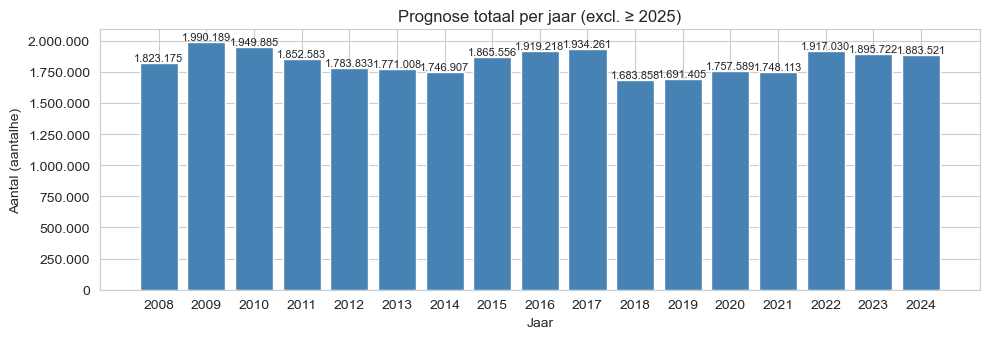

In [68]:
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style("whitegrid")

# Start vanuit prognosesNapoleonAidan (bevat: jaar, maand, aantalhe)
fc = prognosesNapoleonAidan.copy()

# Uitsluiten van 2025 en later
fc = fc[fc["jaar"] <= 2024]

# Periodekolom (1e dag van maand) indien nog niet aanwezig
if "periode" not in fc.columns:
    fc["periode"] = pd.to_datetime(dict(year=fc["jaar"], month=fc["maand"], day=1), errors="coerce")
fc = fc.dropna(subset=["periode", "aantalhe"])

# 2) Jaartotalen (alle artikelen samen)
from matplotlib.ticker import FuncFormatter

yearly_tot = (fc.groupby("jaar", as_index=False)["aantalhe"]
                .sum()
                .sort_values("jaar"))

fig, ax = plt.subplots(figsize=(10,3.5))
ax.bar(yearly_tot["jaar"].astype(str), yearly_tot["aantalhe"], color="steelblue")
ax.set_ylim(bottom=0)
ax.set_title("Prognose totaal per jaar (excl. ≥ 2025)")
ax.set_xlabel("Jaar"); ax.set_ylabel("Aantal (aantalhe)")
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}".replace(",", ".")))

for i, v in enumerate(yearly_tot["aantalhe"]):
    ax.text(i, v, f"{int(v):,}".replace(",", "."), ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()

C:\Users\aidan\AppData\Local\Temp\ipykernel_4008\3102429111.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=yearly.index, y=yearly.values, palette="Blues")


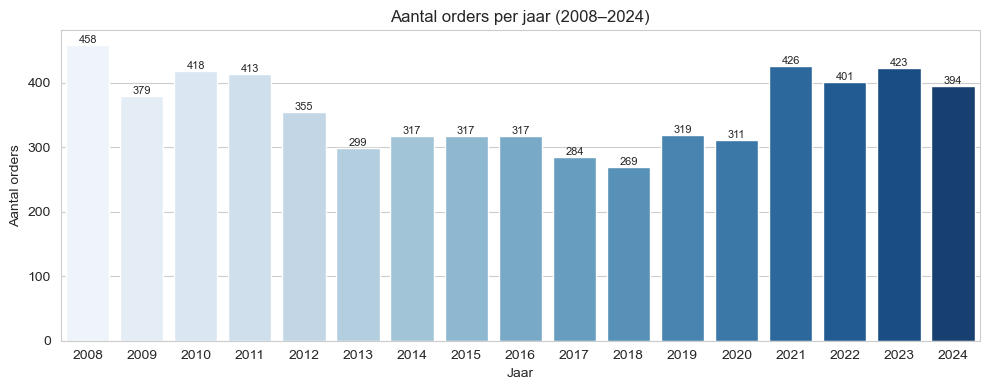

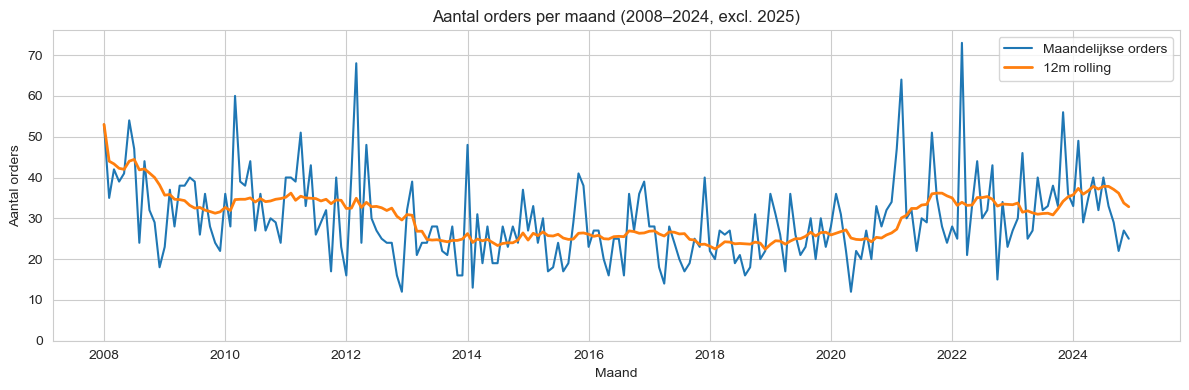

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# --- 1. OrderDate kolom parsen ---
df = orderinfoNapoleonAidan.copy()
df["orderDate"] = pd.to_datetime(df["orderDate"].astype(str), errors="coerce")
df = df.dropna(subset=["orderDate"])

# --- 2. Filter jaren 2008–2024 ---
df = df[(df["orderDate"].dt.year >= 2008) & (df["orderDate"].dt.year <= 2024)]

# --- 3. Jaarlijkse aggregatie ---
yearly = df.groupby(df["orderDate"].dt.year).size()

plt.figure(figsize=(10,4))
sns.barplot(x=yearly.index, y=yearly.values, palette="Blues")
plt.title("Aantal orders per jaar (2008–2024)")
plt.xlabel("Jaar")
plt.ylabel("Aantal orders")
for i, v in enumerate(yearly.values):
    plt.text(i, v, int(v), ha="center", va="bottom", fontsize=8)
plt.tight_layout()
plt.show()

# --- 4. Maandelijkse aggregatie ---
monthly = df.groupby(df["orderDate"].dt.to_period("M")).size()
monthly.index = monthly.index.to_timestamp()  # omzetten naar datetime index

roll12 = monthly.rolling(12, min_periods=1).mean()

plt.figure(figsize=(12,4))
plt.plot(monthly.index, monthly.values, label="Maandelijkse orders", color="tab:blue")
plt.plot(roll12.index, roll12.values, label="12m rolling", color="tab:orange", linewidth=2)
plt.title("Aantal orders per maand (2008–2024, excl. 2025)")
plt.xlabel("Maand")
plt.ylabel("Aantal orders")
plt.ylim(bottom=0)
plt.legend()
plt.tight_layout()
plt.show()


In [70]:
# Merge orderinfo met opb
df_joined = orderinfoNapoleonAidan.merge(
    opbNapoleonAidan,
    left_on="id", 
    right_on="orderInfoId",
    how="left"   # alleen records met match in beide tabellen
)

print(df_joined.head())
print(df_joined.columns)


   id  orderType  orderStatus clientId clientPlanGroupId               orderDate orderNumber   orderNumberClient  orderNumberYear deliveryAddressId deliveryDate planningDate planningComment invoiceComment   orderModificationDate  removed                          versioninfo importID earliestDeliveryDate latestDeliveryDate invoiceAddressId ventureAddressId loadDateAndTime characteristicId  transportHandling deliveryComment contactpersonId ventureCostCenterID carrierComment  sourcetype  sourceid clientTotalDiscount  opbnr  ordersoort klantnr ordernrintern leverdatum     artikelnummer        ordernrklant deleted  status  ordernr  orderjaar              orderdatum                          artnaam  delivered  orderInfoId  quantity   priceKG  tuWeight
0   1          4            0    10002              None 2007-11-20 16:57:27.243    VO000001  Week 42 - Anta Flu                1              None   2007-10-15   2007-10-14            None           None 2014-04-03 16:56:19.963    False  b'\x0

In [71]:
# alle orderinfo IDs
all_orders = set(orderinfoNapoleonAidan["id"])

# alle orderInfoId's die wél in opb staan
orders_with_opb = set(opbNapoleonAidan["orderInfoId"])

# welke orders missen?
missing_orders = all_orders - orders_with_opb
print("Aantal missende:", len(missing_orders))
print("Voorbeeld IDs:", list(missing_orders))

Aantal missende: 26
Voorbeeld IDs: [3328, 3329, 2691, 3588, 2694, 2950, 3334, 3592, 3593, 2699, 3594, 3856, 3862, 3873, 6177, 3875, 3146, 3295, 3296, 2658, 3554, 3564, 2673, 2675, 4215, 3327]


In [72]:
outliers = df_joined[df_joined[QTY_COL] > 50000]
print("Aantal outliers (", QTY_COL, "> 50.000):", len(outliers))
print(outliers[[DATE_COL, QTY_COL]].head(100))
# Overschrijft df_joined met alleen de rijen waarvan de QTY_COL <= 50000
df_joined = df_joined[df_joined[QTY_COL] <= 50000]

Aantal outliers ( quantity > 50.000): 10
                    orderDate      quantity
4002  2008-05-15 09:07:42.937  1.610280e+05
4021  2008-05-20 13:07:12.147  2.592000e+05
14912 2012-12-10 06:57:08.930  5.702400e+04
14930 2012-12-10 06:57:08.930  5.587200e+04
17492 2017-09-04 06:34:11.990  1.015602e+09
28155 2021-08-23 11:48:53.337  1.408384e+07
31141 2018-10-26 06:10:56.570  5.184000e+04
33785 2019-11-27 12:34:51.947  5.132160e+04
35873 2023-04-04 07:33:27.977  9.094500e+04
39617 2024-09-02 07:39:18.067  1.010600e+05


Gebruik datumkolom: orderDate
Gebruik kwantiteitkolom: quantity
Jaarlijkse totalen (eerste 10):
jaar
2008    7562354.637
2009    6840705.271
2010    6486696.961
2011    6969248.704
2012    7071529.441
2013    6946128.076
2014    7344205.535
2015    6730998.386
2016    7088571.595
2017    6369760.710
Name: quantity, dtype: float64


C:\Users\aidan\AppData\Local\Temp\ipykernel_4008\1795245683.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=yearly_qty.index, y=yearly_qty.values, palette="Blues")


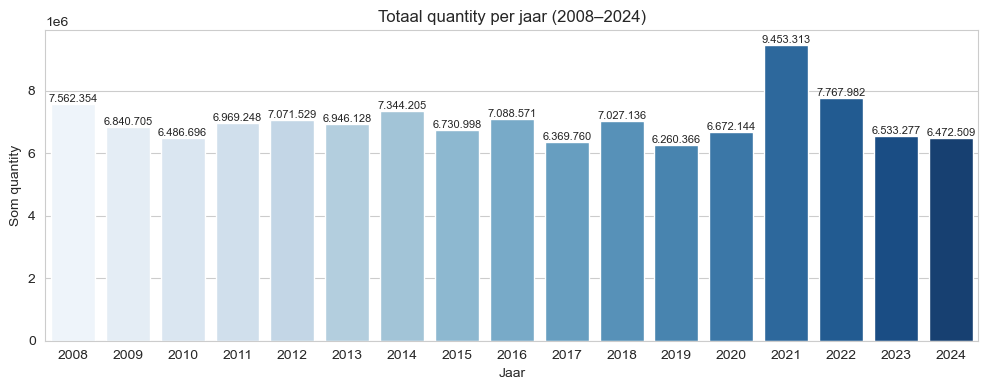

In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

# 1. Datumkolom bepalen (gebruik eerst expliciete namen)
DATE_CANDIDATES = ["orderDate","deliveryDate","planningDate","loadDateAndTime","bestel_datum"]
date_cols_present = [c for c in DATE_CANDIDATES if c in df_joined.columns]
if not date_cols_present:
    # fallback: alle kolommen met 'date' of 'time'
    date_cols_present = [c for c in df_joined.columns if "date" in c.lower() or "time" in c.lower()]
if not date_cols_present:
    raise ValueError("Geen datumkolom gevonden in df_joined.")
DATE_COL = date_cols_present[0]
print("Gebruik datumkolom:", DATE_COL)

# 2. Kwantiteitkolom bepalen
QTY_CANDIDATES = [
    "quantity","qty","aantal","orderQuantity","orderedQty","aantalhe","qtyOrdered"
]
qty_cols_present = [c for c in QTY_CANDIDATES if c in df_joined.columns]

if not qty_cols_present:
    # fallback: pak alle numerieke kolommen behalve id's en datums en kies er één interactief
    num_cols = df_joined.select_dtypes(include="number").columns.tolist()
    blacklist = {"id","orderInfoId"}
    num_cols = [c for c in num_cols if c not in blacklist]
    raise ValueError(f"Geen bekende kwantiteitkolom gevonden. Beschikbare numerieke kolommen: {num_cols}")

QTY_COL = qty_cols_present[0]
print("Gebruik kwantiteitkolom:", QTY_COL)

# 3. Datums parsen
df_qty = df_joined[[DATE_COL, QTY_COL]].copy()
df_qty[DATE_COL] = pd.to_datetime(df_qty[DATE_COL], errors="coerce")
df_qty = df_qty.dropna(subset=[DATE_COL])
df_qty[QTY_COL] = pd.to_numeric(df_qty[QTY_COL], errors="coerce")
df_qty = df_qty.dropna(subset=[QTY_COL])

# 4. Filter jaren 2008–2024 (sluit 2025 uit)
df_qty = df_qty[(df_qty[DATE_COL].dt.year >= 2008) & (df_qty[DATE_COL].dt.year <= 2024)]
if df_qty.empty:
    raise ValueError("Geen rijen binnen jaar-range 2008–2024 na filtering.")

# 5. Jaaraggregatie (som)
yearly_qty = (
    df_qty
      .assign(jaar = df_qty[DATE_COL].dt.year)
      .groupby("jaar")[QTY_COL]
      .sum()
      .sort_index()
)

print("Jaarlijkse totalen (eerste 10):")
print(yearly_qty.head(10))

# 6. Plot
plt.figure(figsize=(10,4))
ax = sns.barplot(x=yearly_qty.index, y=yearly_qty.values, palette="Blues")
plt.title(f"Totaal {QTY_COL} per jaar (2008–2024)")
plt.xlabel("Jaar")
plt.ylabel(f"Som {QTY_COL}")
for i, v in enumerate(yearly_qty.values):
    ax.text(i, v, f"{int(v):,}".replace(",", "."), ha="center", va="bottom", fontsize=8)
plt.tight_layout()
plt.show()

In [74]:
outliers = df_joined[df_joined[QTY_COL] > 50000]
print("Aantal outliers (", QTY_COL, "> 50.000):", len(outliers))
print(outliers[[DATE_COL, QTY_COL]].head(100))
# Overschrijft df_joined met alleen de rijen waarvan de QTY_COL <= 50000
df_joined = df_joined[df_joined[QTY_COL] <= 50000]

Aantal outliers ( quantity > 50.000): 0
Empty DataFrame
Columns: [orderDate, quantity]
Index: []


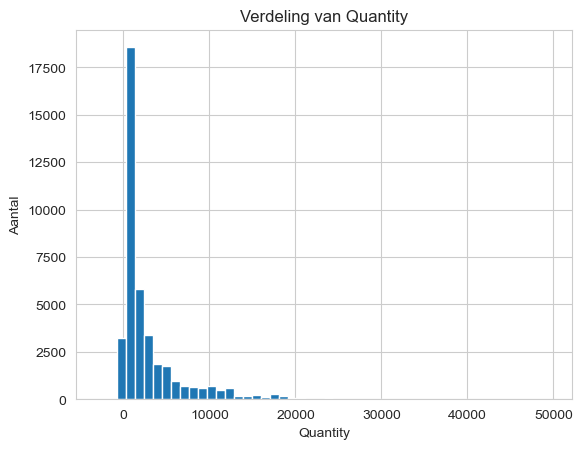

In [75]:
import matplotlib.pyplot as plt

# Histogram van QTY_COL
df_joined['quantity'].hist(bins=50)  # Pas het aantal bins aan naar wens
plt.xlabel('Quantity')
plt.ylabel('Aantal')
plt.title('Verdeling van Quantity')
plt.show()

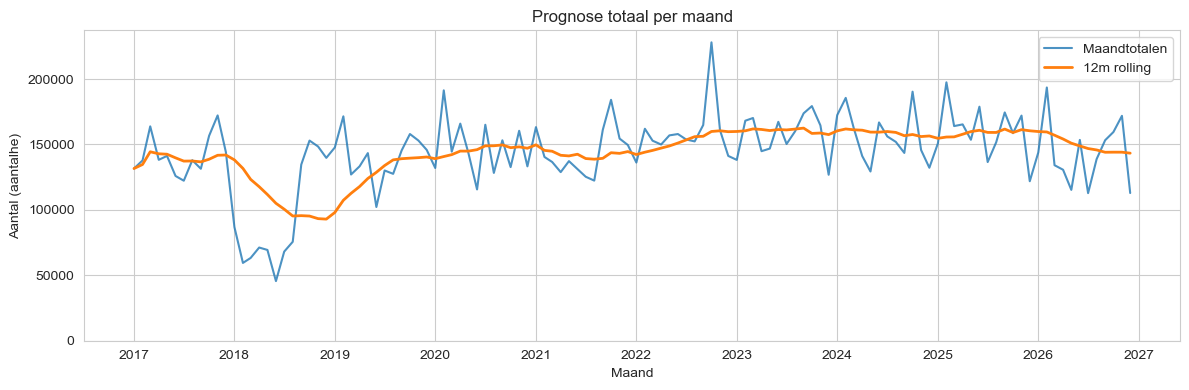

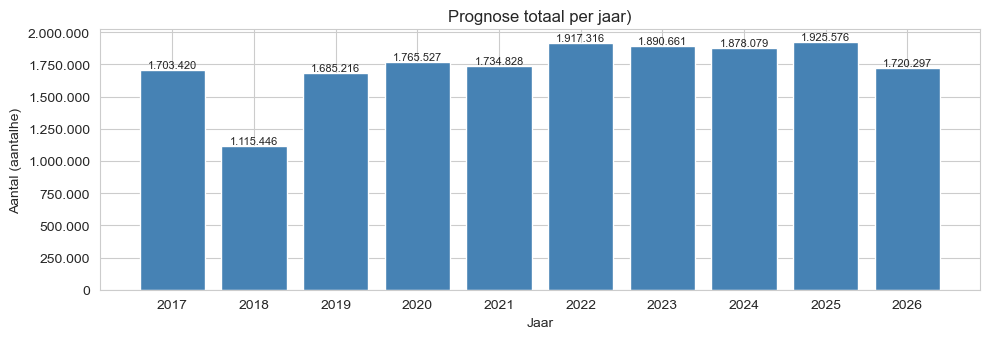

In [76]:
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style("whitegrid")

exclude_years = [2016]
fc = jaarschemaPervasco.copy()

# Uitsluiten van bepaalde jaren
fc = fc[~fc["jaar"].isin(exclude_years)]

# Periodekolom (1e dag van maand) indien nog niet aanwezig
if "periode" not in fc.columns:
    fc["periode"] = pd.to_datetime(dict(year=fc["jaar"], month=fc["maand"], day=1), errors="coerce")
fc = fc.dropna(subset=["periode", "aantalhe"])

# 1) Maandtotalen (alle artikelen samen)
monthly_tot = (fc.groupby("periode")["aantalhe"].sum().sort_index())
roll12 = monthly_tot.rolling(12, min_periods=1).mean()

plt.figure(figsize=(12,4))
plt.plot(monthly_tot.index, monthly_tot.values, label="Maandtotalen", color="tab:blue", alpha=0.8)
plt.plot(roll12.index, roll12.values, label="12m rolling", color="tab:orange", linewidth=2)
plt.ylim(bottom=0)
plt.title("Prognose totaal per maand")
plt.ylabel("Aantal (aantalhe)")
plt.xlabel("Maand")
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.legend()
plt.tight_layout()
plt.show()

# 2) Jaartotalen (alle artikelen samen)
from matplotlib.ticker import FuncFormatter

yearly_tot = (fc.groupby("jaar", as_index=False)["aantalhe"]
                .sum()
                .sort_values("jaar"))

fig, ax = plt.subplots(figsize=(10,3.5))
ax.bar(yearly_tot["jaar"].astype(str), yearly_tot["aantalhe"], color="steelblue")
ax.set_ylim(bottom=0)
ax.set_title("Prognose totaal per jaar)")
ax.set_xlabel("Jaar"); ax.set_ylabel("Aantal (aantalhe)")
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}".replace(",", ".")))

for i, v in enumerate(yearly_tot["aantalhe"]):
    ax.text(i, v, f"{int(v):,}".replace(",", "."), ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()

Gebruik datumkolom: orderDate
Gebruik kwantiteitkolom: quantity
Jaarlijkse totalen (eerste 10):
jaar
2008    2151926.0
2009    1927288.0
2010    1783516.0
2011    1869651.0
2012    1956386.0
2013    1763686.0
2014    1870034.0
2015    1734847.0
2016    1860525.0
2017    1664038.0
Name: normalized_qty, dtype: float64


C:\Users\aidan\AppData\Local\Temp\ipykernel_4008\3272827228.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=yearly_qty.index, y=yearly_qty.values, palette="Blues")


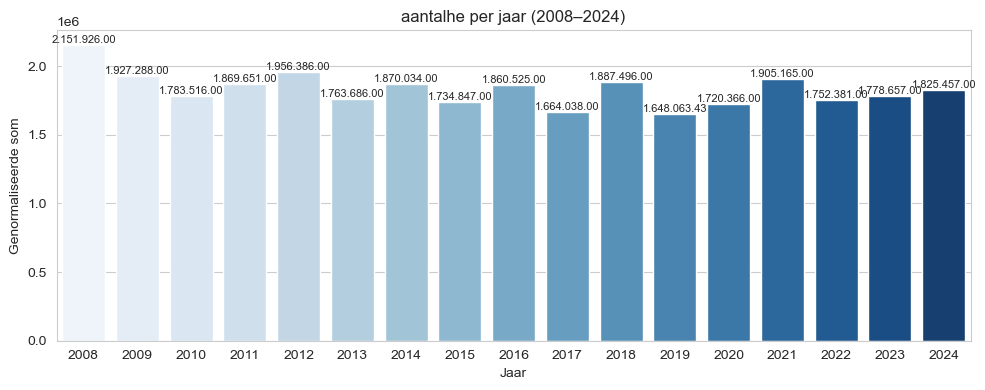

In [77]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

# 1. Datumkolom bepalen
DATE_CANDIDATES = ["orderDate", "deliveryDate", "planningDate", "loadDateAndTime", "bestel_datum"]
date_cols_present = [c for c in DATE_CANDIDATES if c in df_joined.columns]
if not date_cols_present:
    date_cols_present = [c for c in df_joined.columns if "date" in c.lower() or "time" in c.lower()]
if not date_cols_present:
    raise ValueError("Geen datumkolom gevonden in df_joined.")
DATE_COL = date_cols_present[0]
print("Gebruik datumkolom:", DATE_COL)

# 2. Kwantiteitkolom bepalen
QTY_CANDIDATES = ["quantity"]
qty_cols_present = [c for c in QTY_CANDIDATES if c in df_joined.columns]
if not qty_cols_present:
    num_cols = df_joined.select_dtypes(include="number").columns.tolist()
    blacklist = {"id", "orderInfoId"}
    num_cols = [c for c in num_cols if c not in blacklist]
    raise ValueError(f"Geen bekende kwantiteitkolom gevonden. Beschikbare numerieke kolommen: {num_cols}")
QTY_COL = qty_cols_present[0]
print("Gebruik kwantiteitkolom:", QTY_COL)

# 3. Controleren of 'tuWeight' bestaat
if "tuWeight" not in df_joined.columns:
    raise ValueError("Kolom 'tuWeight' niet gevonden in df_joined.")

# 4. Datums & kolommen voorbereiden
df_qty = df_joined[[DATE_COL, QTY_COL, "tuWeight"]].copy()
df_qty[DATE_COL] = pd.to_datetime(df_qty[DATE_COL], errors="coerce")
df_qty = df_qty.dropna(subset=[DATE_COL])

# 5. Numeriek maken
df_qty[QTY_COL] = pd.to_numeric(df_qty[QTY_COL], errors="coerce")
df_qty["tuWeight"] = pd.to_numeric(df_qty["tuWeight"], errors="coerce")

df_qty = df_qty[(df_qty["tuWeight"] > 1)]  # of bijvoorbeeld >1.0 als dat logisch is
if df_qty.empty:
    raise ValueError("Geen geldige rijen na filtering op tuWeight > 0.5.")

# 6. Hoeveelheid per gewichtseenheid berekenen
df_qty["normalized_qty"] = df_qty[QTY_COL] / df_qty["tuWeight"]

# 7. Filter jaren 2008–2024
df_qty = df_qty[(df_qty[DATE_COL].dt.year >= 2008) & (df_qty[DATE_COL].dt.year <= 2024)]
if df_qty.empty:
    raise ValueError("Geen rijen binnen jaar-range 2008–2024 na filtering.")

# 8. Jaaraggregatie (som)
yearly_qty = (
    df_qty
    .assign(jaar=df_qty[DATE_COL].dt.year)
    .groupby("jaar")["normalized_qty"]
    .sum()
    .sort_index()
)

print("Jaarlijkse totalen (eerste 10):")
print(yearly_qty.head(10))

# 9. Plot
plt.figure(figsize=(10, 4))
ax = sns.barplot(x=yearly_qty.index, y=yearly_qty.values, palette="Blues")
plt.title("aantalhe per jaar (2008–2024)")
plt.xlabel("Jaar")
plt.ylabel("Genormaliseerde som")
for i, v in enumerate(yearly_qty.values):
    ax.text(i, v, f"{v:,.2f}".replace(",", "."), ha="center", va="bottom", fontsize=8)
plt.tight_layout()
plt.show()


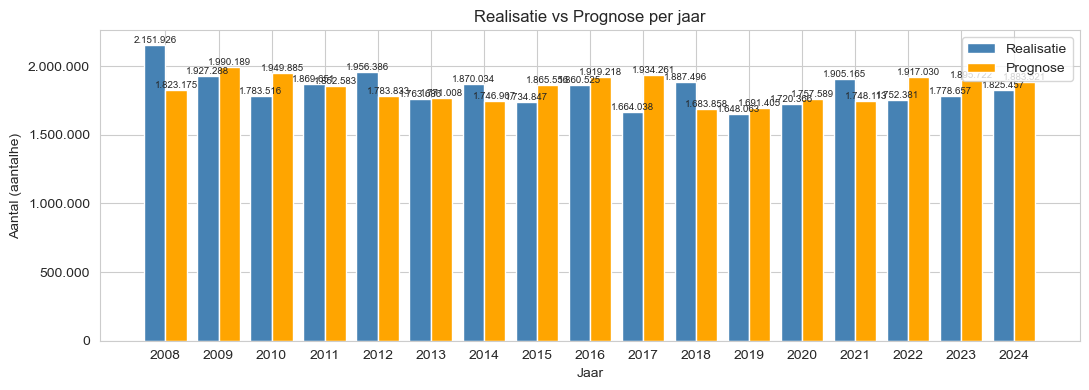

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

sns.set_style("whitegrid")

# -------------------
# 1. Prognoses
# -------------------
fc = prognosesNapoleonAidan.copy()
fc = fc[fc["jaar"] <= 2024]

if "periode" not in fc.columns:
    fc["periode"] = pd.to_datetime(dict(year=fc["jaar"], month=fc["maand"], day=1), errors="coerce")

fc = fc.dropna(subset=["periode", "aantalhe"])

yearly_fc = (
    fc.groupby("jaar", as_index=False)["aantalhe"]
      .sum()
      .sort_values("jaar")
      .rename(columns={"aantalhe": "forecast"})
)

# -------------------
# 2. Realisaties
# -------------------
DATE_CANDIDATES = ["orderDate", "deliveryDate", "planningDate", "loadDateAndTime", "bestel_datum"]
date_cols_present = [c for c in DATE_CANDIDATES if c in df_joined.columns]
if not date_cols_present:
    date_cols_present = [c for c in df_joined.columns if "date" in c.lower() or "time" in c.lower()]
if not date_cols_present:
    raise ValueError("Geen datumkolom gevonden in df_joined.")

DATE_COL = date_cols_present[0]

QTY_CANDIDATES = ["quantity"]
qty_cols_present = [c for c in QTY_CANDIDATES if c in df_joined.columns]
if not qty_cols_present:
    num_cols = df_joined.select_dtypes(include="number").columns.tolist()
    blacklist = {"id", "orderInfoId"}
    num_cols = [c for c in num_cols if c not in blacklist]
    raise ValueError(f"Geen bekende kwantiteitkolom gevonden. Beschikbare numerieke kolommen: {num_cols}")
QTY_COL = qty_cols_present[0]

if "tuWeight" not in df_joined.columns:
    raise ValueError("Kolom 'tuWeight' niet gevonden in df_joined.")

df_qty = df_joined[[DATE_COL, QTY_COL, "tuWeight"]].copy()
df_qty[DATE_COL] = pd.to_datetime(df_qty[DATE_COL], errors="coerce")
df_qty = df_qty.dropna(subset=[DATE_COL])

df_qty[QTY_COL] = pd.to_numeric(df_qty[QTY_COL], errors="coerce")
df_qty["tuWeight"] = pd.to_numeric(df_qty["tuWeight"], errors="coerce")
df_qty = df_qty[df_qty["tuWeight"] > 1]

df_qty["normalized_qty"] = df_qty[QTY_COL] / df_qty["tuWeight"]

df_qty = df_qty[(df_qty[DATE_COL].dt.year >= 2008) & (df_qty[DATE_COL].dt.year <= 2024)]

yearly_real = (
    df_qty
    .assign(jaar=df_qty[DATE_COL].dt.year)
    .groupby("jaar", as_index=False)["normalized_qty"]
    .sum()
    .rename(columns={"normalized_qty": "realisatie"})
)

# -------------------
# 3. Samenvoegen & Plot
# -------------------
df_all = pd.merge(yearly_real, yearly_fc, on="jaar", how="outer").sort_values("jaar")

fig, ax = plt.subplots(figsize=(11, 4))

width = 0.4
x = range(len(df_all))

ax.bar([i - width/2 for i in x], df_all["realisatie"], width=width, label="Realisatie", color="steelblue")
ax.bar([i + width/2 for i in x], df_all["forecast"], width=width, label="Prognose", color="orange")

ax.set_xticks(x)
ax.set_xticklabels(df_all["jaar"].astype(str))
ax.set_ylim(bottom=0)
ax.set_title("Realisatie vs Prognose per jaar")
ax.set_xlabel("Jaar")
ax.set_ylabel("Aantal (aantalhe)")

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}".replace(",", ".")))
ax.legend()

# Labels boven de bars
for i, v in enumerate(df_all["realisatie"]):
    if pd.notna(v):
        ax.text(i - width/2, v, f"{v:,.0f}".replace(",", "."), ha="center", va="bottom", fontsize=7)
for i, v in enumerate(df_all["forecast"]):
    if pd.notna(v):
        ax.text(i + width/2, v, f"{v:,.0f}".replace(",", "."), ha="center", va="bottom", fontsize=7)

plt.tight_layout()
plt.show()


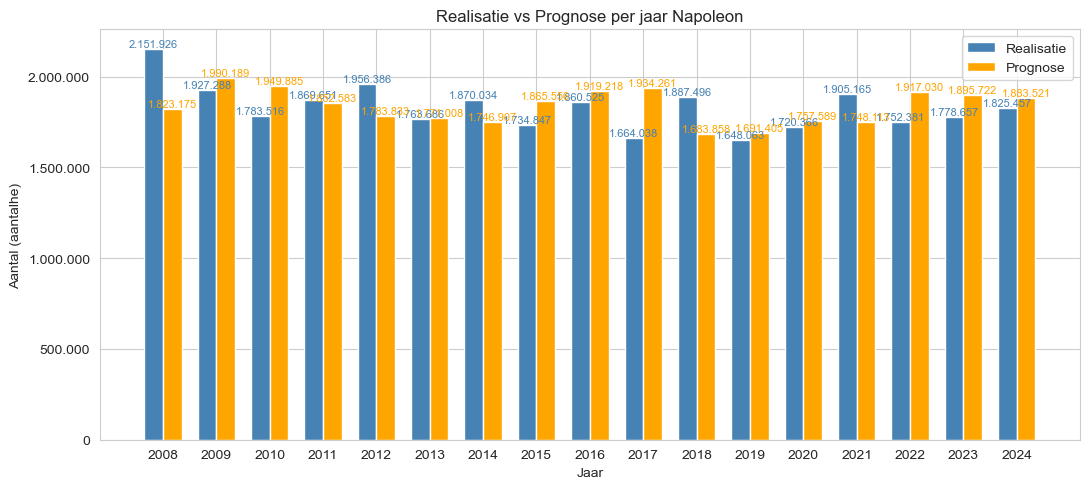

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

sns.set_style("whitegrid")

# -------------------
# 1. Prognoses
# -------------------
fc = prognosesNapoleonAidan.copy()
fc = fc[fc["jaar"] <= 2024]

if "periode" not in fc.columns:
    fc["periode"] = pd.to_datetime(dict(year=fc["jaar"], month=fc["maand"], day=1), errors="coerce")

fc = fc.dropna(subset=["periode", "aantalhe"])

yearly_fc = (
    fc.groupby("jaar", as_index=False)["aantalhe"]
      .sum()
      .sort_values("jaar")
      .rename(columns={"aantalhe": "forecast"})
)

# -------------------
# 2. Realisaties
# -------------------
DATE_CANDIDATES = ["orderDate", "deliveryDate", "planningDate", "loadDateAndTime", "bestel_datum"]
date_cols_present = [c for c in DATE_CANDIDATES if c in df_joined.columns]
if not date_cols_present:
    date_cols_present = [c for c in df_joined.columns if "date" in c.lower() or "time" in c.lower()]
if not date_cols_present:
    raise ValueError("Geen datumkolom gevonden in df_joined.")

DATE_COL = date_cols_present[0]

QTY_CANDIDATES = ["quantity"]
qty_cols_present = [c for c in QTY_CANDIDATES if c in df_joined.columns]
if not qty_cols_present:
    num_cols = df_joined.select_dtypes(include="number").columns.tolist()
    blacklist = {"id", "orderInfoId"}
    num_cols = [c for c in num_cols if c not in blacklist]
    raise ValueError(f"Geen bekende kwantiteitkolom gevonden. Beschikbare numerieke kolommen: {num_cols}")
QTY_COL = qty_cols_present[0]

if "tuWeight" not in df_joined.columns:
    raise ValueError("Kolom 'tuWeight' niet gevonden in df_joined.")

df_qty = df_joined[[DATE_COL, QTY_COL, "tuWeight"]].copy()
df_qty[DATE_COL] = pd.to_datetime(df_qty[DATE_COL], errors="coerce")
df_qty = df_qty.dropna(subset=[DATE_COL])

df_qty[QTY_COL] = pd.to_numeric(df_qty[QTY_COL], errors="coerce")
df_qty["tuWeight"] = pd.to_numeric(df_qty["tuWeight"], errors="coerce")
df_qty = df_qty[df_qty["tuWeight"] > 1]

df_qty["normalized_qty"] = df_qty[QTY_COL] / df_qty["tuWeight"]

df_qty = df_qty[(df_qty[DATE_COL].dt.year >= 2008) & (df_qty[DATE_COL].dt.year <= 2024)]

yearly_real = (
    df_qty
    .assign(jaar=df_qty[DATE_COL].dt.year)
    .groupby("jaar", as_index=False)["normalized_qty"]
    .sum()
    .rename(columns={"normalized_qty": "realisatie"})
)

# -------------------
# 3. Samenvoegen
# -------------------
df_all = pd.merge(yearly_real, yearly_fc, on="jaar", how="outer").sort_values("jaar")

# -------------------
# 4. Plot (beide als bars, afgerond)
# -------------------
fig, ax = plt.subplots(figsize=(11, 5))

width = 0.35
x = range(len(df_all))

# Realisaties (links)
ax.bar([i - width/2 for i in x], df_all["realisatie"], width=width, label="Realisatie", color="steelblue")

# Prognoses (rechts)
ax.bar([i + width/2 for i in x], df_all["forecast"], width=width, label="Prognose", color="orange")

ax.set_xticks(x)
ax.set_xticklabels(df_all["jaar"].astype(str))
ax.set_ylim(bottom=0)
ax.set_title("Realisatie vs Prognose per jaar Napoleon")
ax.set_xlabel("Jaar")
ax.set_ylabel("Aantal (aantalhe)")

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}".replace(",", ".")))
ax.legend()

# Labels op balken (afgerond op hele getallen)
for i, v in enumerate(df_all["realisatie"]):
    if pd.notna(v):
        ax.text(i - width/2, v, f"{round(v):,}".replace(",", "."), ha="center", va="bottom", fontsize=8, color="steelblue")
for i, v in enumerate(df_all["forecast"]):
    if pd.notna(v):
        ax.text(i + width/2, v, f"{round(v):,}".replace(",", "."), ha="center", va="bottom", fontsize=8, color="orange")

plt.tight_layout()
plt.show()


In [80]:
import pandas as pd
import pyodbc
from dotenv import load_dotenv
import os
load_dotenv()
conn = pyodbc.connect(
        f"DRIVER={{SQL Server}};"
        f"SERVER={os.getenv('DB_SERVER')};"
        f"UID={os.getenv('DB_USER')};"
        f"PWD={os.getenv('DB_PASSWORD')}"
    )

query = "SELECT * FROM [4food.aidan].[dbo].[prognosesPervasco]"
prognosesPervascoAidan = pd.read_sql_query(query, conn)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)
prognosesPervascoAidan.head(5)

C:\Users\aidan\AppData\Local\Temp\ipykernel_4008\2026260620.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  prognosesPervascoAidan = pd.read_sql_query(query, conn)


,id,jaar,maand,klant,artikel,aantalhe
0,273,2017,1,01001,01000422,5000
1,285,2017,1,15013,01003704,320
2,297,2017,1,15013,02003706,320
3,317,2017,1,15013,03503785,160
4,397,2017,1,16013,01003704,288


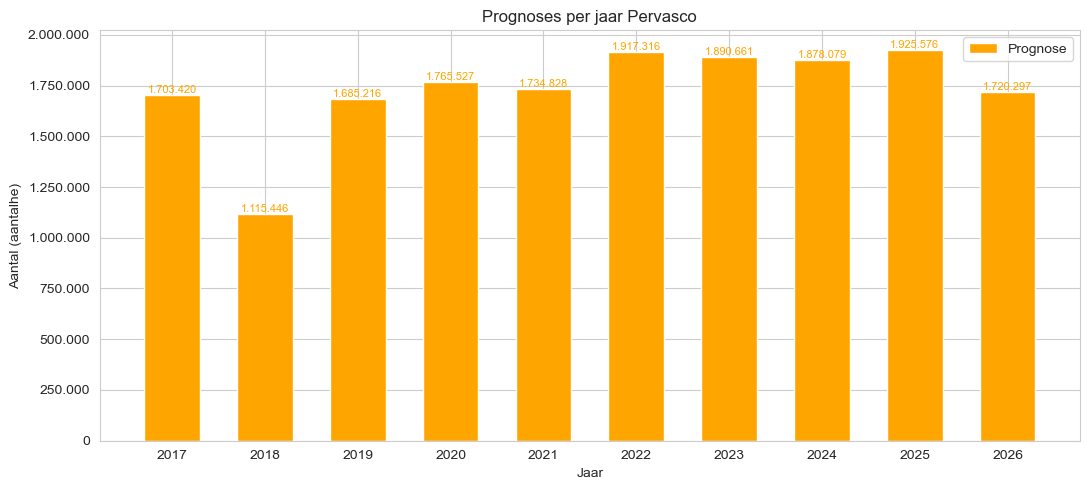

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

sns.set_style("whitegrid")

# -------------------
# 1. Prognoses
# -------------------
fc = prognosesPervascoAidan.copy()

if "periode" not in fc.columns:
    fc["periode"] = pd.to_datetime(dict(year=fc["jaar"], month=fc["maand"], day=1), errors="coerce")

fc = fc.dropna(subset=["periode", "aantalhe"])

yearly_fc = (
    fc.groupby("jaar", as_index=False)["aantalhe"]
      .sum()
      .sort_values("jaar")
      .rename(columns={"aantalhe": "forecast"})
)

# -------------------
# 2. Plot alleen prognoses
# -------------------
fig, ax = plt.subplots(figsize=(11, 5))

x = range(len(yearly_fc))

ax.bar(x, yearly_fc["forecast"], width=0.6, color="orange", label="Prognose")

ax.set_xticks(x)
ax.set_xticklabels(yearly_fc["jaar"].astype(str))
ax.set_ylim(bottom=0)
ax.set_title("Prognoses per jaar Pervasco")
ax.set_xlabel("Jaar")
ax.set_ylabel("Aantal (aantalhe)")

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y):,}".replace(",", ".")))
ax.legend()

# Labels op balken (afgerond op hele getallen)
for i, v in enumerate(yearly_fc["forecast"]):
    if pd.notna(v):
        ax.text(i, v, f"{round(v):,}".replace(",", "."), ha="center", va="bottom", fontsize=8, color="orange")

plt.tight_layout()
plt.show()



In [82]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40980 entries, 0 to 41015
Data columns (total 50 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     40980 non-null  int64         
 1   orderType              40980 non-null  int64         
 2   orderStatus            40980 non-null  int64         
 3   clientId               40980 non-null  object        
 4   clientPlanGroupId      0 non-null      object        
 5   orderDate              40980 non-null  datetime64[ns]
 6   orderNumber            40980 non-null  object        
 7   orderNumberClient      40980 non-null  object        
 8   orderNumberYear        40980 non-null  int64         
 9   deliveryAddressId      0 non-null      object        
 10  deliveryDate           40965 non-null  datetime64[ns]
 11  planningDate           40980 non-null  datetime64[ns]
 12  planningComment        5367 non-null   object        
 13  invoic

In [83]:
df_joined.describe()

,id,orderType,orderStatus,orderDate,orderNumberYear,deliveryDate,planningDate,orderModificationDate,loadDateAndTime,transportHandling,sourcetype,sourceid,opbnr,ordersoort,leverdatum,status,ordernr,orderjaar,orderdatum,delivered,orderInfoId,quantity,priceKG,tuWeight
count,40980.000000,40980.000000,40980.000000,40980,40980.000000,40965,40980,40980,20760,40980.000000,34157.000000,5367.000000,40980.000000,40980.000000,40962,40980.000000,40980.000000,39391.000000,40980,35325.000000,40980.000000,40980.000000,40980.000000,40980.000000
mean,3130.631942,4.206198,2.814959,2016-06-08 23:27:42.951199232,1336.991850,2016-07-12 19:58:49.808865024,2016-07-11 05:59:07.488836096,2017-03-25 08:17:39.166298880,2012-04-10 17:58:27.807716352,0.637555,0.984015,2325.371902,22666.083919,4.202879,2016-07-13 03:08:00.851036416,3.129356,1337.610883,415.838237,2016-06-21 01:24:04.594866176,3012.188133,3130.631942,2997.741001,18.540106,10.247632
min,1.000000,0.000000,0.000000,2007-11-20 16:57:27.243000,1.000000,1905-05-27 00:00:00,1905-05-26 00:00:00,2008-08-20 14:34:30.087000,1905-05-26 00:00:00,0.000000,0.000000,0.000000,17.000000,0.000000,1905-05-27 00:00:00,0.000000,1.000000,0.000000,2007-11-20 16:57:27.243000,-2898.000000,1.000000,-2898.000000,-9000.000000,-3.150000
25%,1791.000000,2.000000,2.000000,2012-03-01 09:55:55.476999936,265.000000,2012-03-22 00:00:00,2012-03-25 00:00:00,2014-04-03 16:56:19.963000064,2009-12-07 00:00:00,0.000000,1.000000,0.000000,10398.750000,2.000000,2012-03-26 00:00:00,2.000000,265.000000,0.000000,2012-03-01 09:55:55.476999936,600.000000,1791.000000,600.000000,1.687500,2.700000
50%,3137.000000,4.000000,3.000000,2016-05-31 12:59:05.667000064,1081.000000,2016-07-11 00:00:00,2016-07-10 00:00:00,2016-07-07 05:58:56.910000128,2012-04-09 00:00:00,1.000000,1.000000,0.000000,21875.500000,4.000000,2016-07-11 00:00:00,3.000000,1082.500000,0.000000,2016-06-15 13:20:40.556999936,1267.200000,3137.000000,1209.600000,1.888384,3.408000
75%,4437.000000,4.000000,3.000000,2020-10-05 07:38:44.403000064,2221.000000,2020-10-19 00:00:00,2020-10-18 00:00:00,2020-11-05 11:19:11.716999936,2014-08-27 00:00:00,1.000000,1.000000,5111.000000,34879.250000,4.000000,2020-10-19 00:00:00,4.000000,2221.000000,0.000000,2020-10-20 10:16:06.127000064,3326.400000,4437.000000,3240.000000,2.283333,5.000000
max,6266.000000,19.000000,6.000000,2025-03-26 09:27:49.977000,3944.000000,2104-10-27 00:00:00,2104-10-26 00:00:00,2025-03-26 16:43:39.760000,2104-10-26 00:00:00,1.000000,3.000000,11060.000000,47139.000000,19.000000,2104-10-27 00:00:00,6.000000,3944.000000,2025.000000,2025-03-26 09:27:49.977000,49536.000000,6266.000000,49536.000000,90000.000000,400.000000
std,1705.379241,3.386460,1.288852,NaN,1184.639468,NaN,NaN,NaN,NaN,0.480712,0.400377,2647.417035,13833.276760,3.388202,NaN,1.157409,1184.328867,816.697080,NaN,4410.801523,1705.379241,4458.464289,925.819198,44.931373


In [10]:
import pandas as pd
import pyodbc
from dotenv import load_dotenv
import os
load_dotenv()
conn = pyodbc.connect(
        f"DRIVER={{SQL Server}};"
        f"SERVER={os.getenv('DB_SERVER')};"
        f"UID={os.getenv('DB_USER')};"
        f"PWD={os.getenv('DB_PASSWORD')}"
    )

query = "SELECT * FROM [4food.aidan].[dbo].[test]"
testAidan = pd.read_sql_query(query, conn)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)
testAidan.head(5)

C:\Users\aidan\AppData\Local\Temp\ipykernel_13648\1390712017.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  testAidan = pd.read_sql_query(query, conn)


,OrderId,OrderType,OrderStatus,ClientId,OrderDate,Artikelnummer,Quantity,PriceKG,TuWeight,Artnaam
0,48046,2,3,120003,2023-09-06 10:32:25,1239PK02,1.56,13.60,1.56,Praline Manon - Hazelnootpraliné&Caramel (Puur...
1,48046,2,3,120003,2023-09-06 10:32:25,1240MK03,2.08,13.60,2.08,Praline Kogel - Speculooscrème & Speculooskrui...
2,48046,2,3,120003,2023-09-06 10:32:25,1241WK02,2.58,13.60,1.29,Praline Bloem - Appeltaartvulling (Wit met gro...
3,48046,2,3,120003,2023-09-06 10:32:25,1700WR02,3.20,17.73,1.60,Praline Tompouce - Verse room vanille (Wit met...
4,48046,2,3,120003,2023-09-06 10:32:25,1701MW01,1.33,17.73,1.33,Praline Cupje Vierkant - Hazelnootpraliné (Wi...


In [2]:
import pandas as pd
import pyodbc
from dotenv import load_dotenv
import os
load_dotenv()
conn = pyodbc.connect(
        f"DRIVER={{SQL Server}};"
        f"SERVER={os.getenv('DB_SERVER')};"
        f"UID={os.getenv('DB_USER')};"
        f"PWD={os.getenv('DB_PASSWORD')}"
    )

query = "SELECT * FROM [4food.aidan].[dbo].[Napoleon_Realisaties]"
napoleonRealisaties = pd.read_sql_query(query, conn)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)
napoleonRealisaties.head(5)

C:\Users\aidan\AppData\Local\Temp\ipykernel_20352\280591871.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  napoleonRealisaties = pd.read_sql_query(query, conn)


,Jaar,Maand,Artikelnummer,Artnaam,TotaalQuantity,GemiddeldePrijs,GemiddeldTuWeight
0,2008,1,101-12-0225-0000,NAP Lempur 12 x 225 g.-e-AH,2970.0,1.967,2.700
1,2008,1,104-03-3000-0000,NAP Fruitmix 3 x 3 kg-e-,1296.0,1.851,9.000
2,2008,1,104-12-0225-0000,NAP Fruitmix 12 x 225 g-e-,594.0,1.981,2.700
3,2008,1,104-15-0225-0000,NAP Fruitmix 15 x 225 g-e-,6480.0,1.970,3.375
4,2008,1,201-12-0275-0000,AF Classic 12 x 275 g-e-,27984.0,1.827,3.300


In [6]:
import pandas as pd
import pyodbc
from dotenv import load_dotenv
import os
load_dotenv()
conn = pyodbc.connect(
        f"DRIVER={{SQL Server}};"
        f"SERVER={os.getenv('DB_SERVER')};"
        f"UID={os.getenv('DB_USER')};"
        f"PWD={os.getenv('DB_PASSWORD')}"
    )

query = "SELECT * FROM [4food.aidan].[dbo].[Napoleon_All]"
napoleonAllData = pd.read_sql_query(query, conn)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)
napoleonAllData.head(5)

C:\Users\aidan\AppData\Local\Temp\ipykernel_13648\842322701.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  napoleonAllData = pd.read_sql_query(query, conn)


,OrderId,OrderType,OrderStatus,ClientId,OrderDate,Artikelnummer,Quantity,PriceKG,TuWeight,Artnaam
0,637,4,3,10002,2009-04-22 13:01:47.057,305-14-0200-0000,1680.0,2.104,2.80,Lemco Mixzak vruchten / salmiak 14 x 200 g.
1,637,4,3,10002,2009-04-22 13:01:47.057,201-12-0275-0000,5280.0,1.827,3.30,AF Classic 12 x 275 g-e-
2,637,4,3,10002,2009-04-22 13:01:47.057,201-05-1000-0000,1200.0,1.804,5.00,AF Classic 5 x 1 kg-e-
3,637,4,3,10002,2009-04-22 13:01:47.057,201-18-0175-0000,2520.0,1.854,3.15,AF Classic 18 x 175 g-e-
4,637,4,3,10002,2009-04-22 13:01:47.057,203-05-1000-0000,600.0,1.780,5.00,AF Menthol/eucalyptus 5 x 1 kg-e-


In [5]:
import pandas as pd
import pyodbc
from dotenv import load_dotenv
import os
load_dotenv()
conn = pyodbc.connect(
        f"DRIVER={{SQL Server}};"
        f"SERVER={os.getenv('DB_SERVER')};"
        f"UID={os.getenv('DB_USER')};"
        f"PWD={os.getenv('DB_PASSWORD')}"
    )

query = "SELECT * FROM [4food.napoleon.productie].[dbo].[orderinfo]"
opbNapoleon = pd.read_sql_query(query, conn)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)
opbNapoleon.head(5)

C:\Users\aidan\AppData\Local\Temp\ipykernel_5756\158272216.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  opbNapoleon = pd.read_sql_query(query, conn)


,id,orderType,orderStatus,clientId,clientPlanGroupId,orderDate,orderNumber,orderNumberClient,orderNumberYear,deliveryAddressId,deliveryDate,planningDate,planningComment,invoiceComment,orderModificationDate,removed,versioninfo,importID,earliestDeliveryDate,latestDeliveryDate,invoiceAddressId,ventureAddressId,loadDateAndTime,characteristicId,transportHandling,deliveryComment,contactpersonId,ventureCostCenterID,carrierComment,sourcetype,sourceid,clientTotalDiscount
0,1,4,0,10002,None,2007-11-20 16:57:27.243,VO000001,Week 42 - Anta Flu,1,None,2007-10-15,2007-10-14,None,None,2014-04-03 16:56:19.963,False,b'\x00\x00\x00\x00\x00\xc9\x02\xf7',None,None,None,None,None,2007-10-14,None,1,None,None,None,None,1.0,NaN,None
1,2,4,0,10002,None,2007-11-20 16:57:27.243,VO000002,Week 45 - Napoleon,2,None,2007-11-05,2007-11-04,None,None,2014-04-03 16:56:19.963,False,b'\x00\x00\x00\x00\x00\xc9\x02\xf8',None,None,None,None,None,2007-11-04,None,1,None,None,None,None,1.0,NaN,None
2,3,4,1,10002,None,2007-11-20 16:57:27.243,VO000003,Week 47,3,None,2007-11-19,2007-11-18,None,None,2014-04-03 16:56:19.963,False,b'\x00\x00\x00\x00\x00\xfd$\x89',None,None,None,None,None,2007-11-18,None,1,None,None,None,None,1.0,NaN,None
3,4,0,0,10002,None,2007-11-20 16:57:27.243,VO070001,1,1,None,2007-04-28,2007-04-27,None,None,2014-04-03 16:56:19.963,False,b'\x00\x00\x00\x00\x00\xc9\x02\xfa',None,None,None,None,None,2007-04-27,None,1,None,None,None,None,1.0,NaN,None
4,5,0,0,10002,None,2007-11-20 16:57:27.243,VO070002,2,2,None,2007-05-08,2007-05-07,None,None,2014-04-03 16:56:19.963,False,b'\x00\x00\x00\x00\x00\xc9\x02\xfb',None,None,None,None,None,2007-05-07,None,1,None,None,None,None,1.0,NaN,None
